In [132]:
import numpy as np

import pandas as pd
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_colwidth', 100)

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator

import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")
sns.set_palette("bright")

import math
import sqlite3
from datetime import date, datetime as dt
from dateutil.relativedelta import relativedelta as delta
import re
import unicodedata

from nlp_utils import get_english_stopwords, get_corpus_stopwords
from nlp_utils import CONTRACTION_MAP, CONVERSATIONAL_ABBREVIATION_MAP
from nlp_utils import print_completion_message
from nlp_utils import plot_label_frequencies, plot_document_frequencies, average_token_length

from classification_utils import plot_validation_confusion_matrices, plot_multilabel_validation_metrics, plot_multilabel_validation_metrics, get_classification_metrics

from nn_utils import plot_history

import nltk
from nltk import pos_tag as pos_tag_words 
from nltk import pos_tag_sents as pos_tag_sentences 
from nltk.tokenize import word_tokenize, sent_tokenize 
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.class_weight import compute_sample_weight

import tensorflow as tf
from keras import Model
from keras.models import Sequential, load_model
from keras.layers import Layer, TextVectorization, Input, Embedding, Dense, Dropout, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.initializers import Constant
from keras.utils import plot_model


FRACTION = 0.15


# A. *Business Context*


*FP1 Strategies* is a campaign consulting and advertising firm dedicated to helping Republican candidates achieve political success. However, the divide between Liberals and Conservatives has been growing at an alarming rate these last few decades, and this has dramatically affected the American political landscape. Within the Republican and Democratic parties, the number of memebers with a highly negative view of the opposing party has more than doubled since 1994, while the ideological overlap between the two parties has diminished greatly.[^1]

This team at *FP1 Strategies* sees the in **partisanship** as an oppurtunity. They believe that, because of the factors discussed above, candidates who attempt to placate both sides, trying to be pallatable to everyone, are destined to fail. Those who are willing to take a more direct and authentic approach, who can resonate with the Conservative demographic, can achieve great success. However, the company needs a better way of identifying and reaching out to the Conservative population. Traditional canvassing is slow, cumbersome, and inefficient. In order to improve this, the team at *FP1 Strategies* has come up with an idea called *remote canvassing*. They want to use machine learning to identify a person's ideological preference (i.e. if they are Conservative/Liberal) solely based on their past activity on social media. If the person is determined to be sufficiently conservative, it is assumed they are likely to vote Republican, and the team would reach out to them online, that is, canvass remotely. This is just half the battle, because they also need to know specifically which issues to address when canvassing for potential supporters. Thus, the requirement of being identified as "sufficiently conservative" has to be done with respect to one of the major societal issues that a political candidate can address and garner support for.

*The company wishes to see a demonstration showing that remote canvassing is practically achievable. It should utilize data form social media to answer the following questions:*
> * **Can we use machine learning to accurately determine whether someone takes a Conservative/Liberal stance on an issue?**

# B. *Data Understanding*

## B.1 - Background Information


Collecting data was an involved process. The Conservative and Liberal ideologies are vast, and they play a part in almost every domain of modern life in the United States. Among the numerous issues that parallell the Conservative/Liberal divide, a set of $5$ were chosen. One has to make sure they are polarizing enough to provide meaningful data, yet not too complex or multi-faceted that data collection becomes difult. These issues were:

* Abortion
* Immigration
* Healthcare
* Gun Control
* Climate Change

Distilling Conservative/Liberal beliefs into a set of cultural issues was necessary because one's stance in regards to each these issues can indeed be quantified with data. The idea is that a person can be identified as Conservative/Liberal by considering the their stance on these contentious topics.

For each of the issues listed above, it is important to define what is meant by a "liberal" viewpoint and a "conservative" viewpoint. The generally accepted definitions of these are summarized in the following sections.[^2]

##### *Abortion*

* __Liberal:__ A pregnant woman has a right to abort the fetus because she has autonomy over her body.

* __Conservative:__ A fetus is a human being deserving of legal protection, separate from the will of the mother.

##### *Immigration*

* __Liberal:__ Illegal immigrants deserve rights such as financial aid for college tuition and visas for immediate family members back home.

* __Conservative:__ Government should enforce immigration laws. Those who break the law by entering the United States illegally should not have the same rights as those who obey the law by entering the country legally.

##### *Healthcare*

* __Liberal:__ Support universal health care subsidized by the government. Free healthcare is a basic right that everyone is entitled to.

* __Conservative:__ Free healthcare provided by the government (socialized medicine) means that everyone will get the same poor-quality healthcare. The rich will continue to pay for superior healthcare, while the rest of us receive inadequate healthcare from the government.

##### *Gun Control*

* __Liberal:__ The Second Amendment gives no individual the right to own a gun, but allows the state to keep a militia (National Guard/Armed Forces). Guns are too dangerous.

* __Conservative:__ The Second Amendment gives the individual the right to keep and bear arms. Gun control laws do not thwart criminals. You have a right to defend yourself against criminals. More guns mean less crime.

##### *Climate Change*

* __Liberal:__ Industrial growth harms the environment. Therefore, the U.S. should enact laws to significantly
reduce this, even if it comes at the cost of economic growth.

* __Conservative:__ Changes in global temperatures are natural over long periods of time. Science has not definitively proven humans guilty of permanently changing the Earth's climate.

## B.2 - Data Collection


The data is comprised entirely of posts and comments scraped from the Reddit API. Reddit is a massive collection of forums in which various communities (called Subreddits) post content, discuss ideas, and share news. Reddit was an ideal source of data because there are several communities specifically dedicated to discussing one or more of the above mentioned issues, and which represent both the Liberal and Conservative sides of the debate. Therefore, data was labeled simply according to the Subreddit it belonged to. The process began by manually searching Reddit and curating a group of Subreddits whose community fell under one of the $5$ controversial topics discussed above.

In addition, subreddits pertaining to ideological preference (Conservative/Liberal) and partisanship (Republican/Democrat) were identified and scraped.

It is important to note that two of the Subreddits were used to find posts pertaining to more than one issue. Namely, the `r/AskTrumpSupporters` and `r/Political_Revolution` Subreddits. This could be done because their posts were tagged by sub-topic. (In Reddit language, this is referred to as post *flair*).

The complete list of curated Subredits is shown below:

- **`r/progun`** [Issue(s): **Gun Control** | Stance: **Conservative**]
- **`r/Firearms`** [Issue(s): **Gun Control** | Stance: **Conservative**]
- **`r/gunpolitics`** [Issue(s): **Gun Control** | Stance: **Conservative**]
- **`r/prolife`** [Issue(s): **Abortion** | Stance: **Conservative**]
- **`r/AskTrumpSupporters`** [Issue(s): **Climate Change**, **Immigration**, **Healthcare** | Stance: **Conservative**]
- **`r/climateskeptics`** [Issue(s): **Climate Change** | Stance: **Conservative**]
- **`r/Conservative`** [Issue(s): **Ideology** | Stance: **Conservative**]
- **`r/ConservativesOnly`** [Issue(s): **Ideology** | Stance: **Conservative**]
- **`r/Republican`** [Issue(s): **Partisanship** | Stance: **Conservative**]
- **`r/GunsAreCool`** [Issue(s): **Gun Control** | Stance: **Liberal**]
- **`r/guncontrol`** [Issue(s): **Gun Control** | Stance: **Liberal**]
- **`r/prochoice`** [Issue(s): **Abortion** | Stance: **Liberal**]
- **`r/climate`** [Issue(s): **Climate Change** | Stance: **Liberal**]
- **`r/ClimateOffensive`** [Issue(s): **Climate Change** | Stance: **Liberal**]
- **`r/JoeBiden`** [Issue(s): **Immigration** | Stance: **Liberal**]
- **`r/MedicareForAll`** [Issue(s): **Healthcare** | Stance: **Liberal**]
- **`r/Political_Revolution`** [Issue(s): **Immigration**, **Healthcare** | Stance: **Liberal**]
- **`r/Liberal`** [Issue(s): **Ideology** | Stance: **Liberal**]
- **`r/progressive`** [Issue(s): **Ideology** | Stance: **Liberal**]
- **`r/democrats`** [Issue(s): **Partisanship** | Stance: **Liberal**]


All of the Subreddits above contain anywhere from thousands to tens of thousands of posts. To make the selection process easier, the most popular posts from each Subreddit were collected, along with their comment threads.


Data extracted from the from the Reddit API was stored in the database file: `data/reddit_data.db`. The schema for this database is shown below:

<br>

<center><img src="images/database-schema.png" width='600'></center>

## B.3 - Data Description

####  *Subreddits*

> *The `subreddits` table contains the following columns:*
> * __id__ *[int] - unique identifier of the (name, issue) pair*
> * __name__ *[str] - name of subreddit*
> * __suscribers__ *[int] - number of users subscribed to subreddit*
> * __issue__ *[str] - subreddit topic (`abortion` | `immigration`|`healthcare` | `gun_control` | `climate` | `party` | `ideology`)*
> * __stance__ *[str] - overall stance taken by the subreddit's community (`conservative` | `liberal`)*


#### *Posts*

> *The `posts` table contains the following columns:*
> * __id__ *[str] - unique identifier of the post*
> * __subreddit_id__ *[int] - unique identifier of the parent subreddit*
> * __author_id__ *[int] - unique identifier of the posts's author*
> * __title__ *[int] - title of the post*
> * __score__ *[str] - number of upvotes the post has recieved in its lifetime*
> * __upvote_ratio__ *[float] - ratio of upvotes to downvotes*
> * __date__ *[int] - date the post was created (Unix time stamp)*

#### *Comments*

> *The `comments` table contains the following columns:*
> * __id__ *[str] - unique identifier of the comment*
> * __subreddit_id__ *[int] - unique identifier of subreddit containing the parent post*
> * __post_id__ *[int] - unique identifier of parent post*
> * __author_id__ *[int] - unique identifier of the posts's author*
> * __body__ *[int] - the comment's main body of text*
> * __score__ *[str] - number of upvotes the comment has recieved in its lifetime*
> * __date__ *[int] - date the comment was created (Unix time stamp)*

#### *Users*

> *The `users` table contains the following columns:*
> * __id__ *[str] - unique identifier of a Reddit user identified in the `posts`/`comments` table*
> * __subreddit_id__ *[int] - unique identifier of subreddit in which the above Reddit user created a post/comment*


## B.4 - Importing the Data

> The `subreddits`, `posts`, and `comments` tables from `data/reddit_data.db` were loaded into memory as DataFrame objects named `subreddit_df`, `post_df`, and `comment_df` respectively.

In [2]:
conn = sqlite3.connect('data/reddit_data.db')

### *B.4.1 - Importing the `subreddits` Table*

In [3]:
query = """--sql
         SELECT id, name, issue, stance
         FROM subreddits
         """
subreddit_df = pd.read_sql(query, conn, index_col="id")

In [4]:
subreddit_df

name        issue        stance
id                                                   
1                 r/progun  gun_control  conservative
2               r/Firearms  gun_control  conservative
3            r/gunpolitics  gun_control  conservative
4                r/prolife     abortion  conservative
5     r/AskTrumpSupporters      climate  conservative
6        r/climateskeptics      climate  conservative
7     r/AskTrumpSupporters  immigration  conservative
8      r/ImmigrationReform  immigration  conservative
9     r/AskTrumpSupporters   healthcare  conservative
10          r/Conservative     ideology  conservative
11     r/ConservativesOnly     ideology  conservative
12            r/Republican        party  conservative
13           r/GunsAreCool  gun_control       liberal
14            r/guncontrol  gun_control       liberal
15             r/prochoice     abortion       liberal
16               r/climate      climate       liberal
17      r/ClimateOffensive      climate       liberal
18              r/JoeBiden  immigration       liberal
19  r/Political_Revolution  immigration       liberal
20        r/MedicareForAll   healthcare       liberal
21  r/Political_Revolution   healthcare       liberal
22               r/Liberal     ideology       liberal
23           r/progressive     ideology       liberal
24             r/democrats        party       liberal

### *B.4.2 - Importing the `posts` Table*

From the `posts` table, the `id` and `date` columns were imported. The `date` column was needed to engineer the `quality` feature [see ***Section C.2***].

In [5]:
query = """--sql
         SELECT id, date 
         FROM posts
         """
post_df = pd.read_sql(query, conn, index_col="id")

In [6]:
post_df.head()

date
id                
gl995u  1589689988
t271tx  1645909454
i9kx4r  1597407632
vmtebe  1656439220
k32a1t  1606621185

### *B.4.3 - Importing the `comments` Table*

In [7]:
query = """--sql
         SELECT id, post_id, subreddit_id, body, score, date 
         FROM comments
         """
comment_df = pd.read_sql(query, conn)

In [8]:
comment_df.head()

id post_id  subreddit_id  \
0  fqwzlb2  gl995u             1   
1  fqw2qz2  gl995u             1   
2  fqw21ew  gl995u             1   
3  fqw5032  gl995u             1   
4  fqw47i6  gl995u             1   

                                                                                                  body  \
0  Please keep your discussion civil per Rule #3. Comments advocating the killing of cops or others...   
1  Plainclothes, no knock in the middle of the night, wrong house and killed an innocent woman. Pre...   
2  I hope this guy sues and the officers involved end up with charges as they murdered his girlfriend.   
3  This is so messed up. Is there anywhere we can donate to his defense?\n\nGOOOD NEWS: found the g...   
4  No knock raids should be illegal. This isn't the first time this has happened. He should be a fr...   

   score        date  
0      1  1589722149  
1   3418  1589691227  
2   1328  1589690687  
3   1075  1589693022  
4    726  1589692378

## B.5 - Creating the Corpus

### *B.5.1 - Converting `comment_df` into a Corpus*

> The `comment_df` DataFrame was converted into a Corpus (denoted as `corpus`), where each document of this Corpus corresponds to the `body` of each comment in `comment_df`. The `body` column was renamed to `text`, such that documents in the Corpus were contained in the `text` column.

In [9]:
corpus = comment_df.rename(columns={"id":"comment_id", "date": "comment_date", "body": "text"})

In [10]:
corpus.head()

comment_id post_id  subreddit_id  \
0    fqwzlb2  gl995u             1   
1    fqw2qz2  gl995u             1   
2    fqw21ew  gl995u             1   
3    fqw5032  gl995u             1   
4    fqw47i6  gl995u             1   

                                                                                                  text  \
0  Please keep your discussion civil per Rule #3. Comments advocating the killing of cops or others...   
1  Plainclothes, no knock in the middle of the night, wrong house and killed an innocent woman. Pre...   
2  I hope this guy sues and the officers involved end up with charges as they murdered his girlfriend.   
3  This is so messed up. Is there anywhere we can donate to his defense?\n\nGOOOD NEWS: found the g...   
4  No knock raids should be illegal. This isn't the first time this has happened. He should be a fr...   

   score  comment_date  
0      1    1589722149  
1   3418    1589691227  
2   1328    1589690687  
3   1075    1589693022  
4    726    1589692378

### *B.5.2 - Appending the Date of each Comment's Parent Post (`post_date`) to the Corpus*

The `date` column in `post_df` was attached to the Corpus as `post_date`. This was done by joining `post_df` to the Corpus on the `post_id` column of the Corpus and then dropping the `post_id` column. Its important to remember that the `comment_date` column represents the date each comment was created, whereas the `post_date` column represents the date the corresponding parent post was created.

In [11]:
corpus = corpus.join(post_df, on="post_id").rename(columns={"date":"post_date"}).drop(columns="post_id")

In [12]:
corpus.head()

comment_id  subreddit_id  \
0    fqwzlb2             1   
1    fqw2qz2             1   
2    fqw21ew             1   
3    fqw5032             1   
4    fqw47i6             1   

                                                                                                  text  \
0  Please keep your discussion civil per Rule #3. Comments advocating the killing of cops or others...   
1  Plainclothes, no knock in the middle of the night, wrong house and killed an innocent woman. Pre...   
2  I hope this guy sues and the officers involved end up with charges as they murdered his girlfriend.   
3  This is so messed up. Is there anywhere we can donate to his defense?\n\nGOOOD NEWS: found the g...   
4  No knock raids should be illegal. This isn't the first time this has happened. He should be a fr...   

   score  comment_date   post_date  
0      1    1589722149  1589689988  
1   3418    1589691227  1589689988  
2   1328    1589690687  1589689988  
3   1075    1589693022  1589689988  
4    726    1589692378  1589689988

### *B.5.3 - Appending the Issue (`issue`) and Stance (`stance`) of each Comment to the Corpus*

The `issue` and `stance` columns in `subreddit_df` were attached to the Corpus. This was done by joining `subreddit_df` to the Corpus on the `subreddit_id` column of the Corpus and then dropping the `subreddit_id` and `subreddit_name` columns. 

In [13]:
corpus = corpus.join(subreddit_df, on="subreddit_id").rename(columns={"name": "subreddit_name"}).drop(columns=["subreddit_id", "subreddit_name"])
corpus = corpus.loc[(corpus.issue != "party") & (corpus.issue != "ideology")]
corpus[["issue", "stance"]] = corpus[["issue", "stance"]].applymap(lambda x: ' '.join(x.split('_')).upper())

In [14]:
corpus.head()

comment_id  \
0    fqwzlb2   
1    fqw2qz2   
2    fqw21ew   
3    fqw5032   
4    fqw47i6   

                                                                                                  text  \
0  Please keep your discussion civil per Rule #3. Comments advocating the killing of cops or others...   
1  Plainclothes, no knock in the middle of the night, wrong house and killed an innocent woman. Pre...   
2  I hope this guy sues and the officers involved end up with charges as they murdered his girlfriend.   
3  This is so messed up. Is there anywhere we can donate to his defense?\n\nGOOOD NEWS: found the g...   
4  No knock raids should be illegal. This isn't the first time this has happened. He should be a fr...   

   score  comment_date   post_date        issue        stance  
0      1    1589722149  1589689988  GUN CONTROL  CONSERVATIVE  
1   3418    1589691227  1589689988  GUN CONTROL  CONSERVATIVE  
2   1328    1589690687  1589689988  GUN CONTROL  CONSERVATIVE  
3   1075    1589693022  1589689988  GUN CONTROL  CONSERVATIVE  
4    726    1589692378  1589689988  GUN CONTROL  CONSERVATIVE

In [15]:
conn.close()

# C. *Data Preparation*

## C.1 - Cleaning the Corpus

### *C.1.1 - Removing Duplicate Comments*

We can see that `corpus` has entries with duplicate values for `comment_id`, which means these entries contain duplicate comments. These duplicates must be resolved.

In [16]:
corpus["comment_id"].is_unique

False

In [17]:
corpus = corpus.drop_duplicates("comment_id").set_index("comment_id")

In [18]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73472 entries, fqwzlb2 to e05rx4e
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          73472 non-null  object
 1   score         73472 non-null  int64 
 2   comment_date  73472 non-null  int64 
 3   post_date     73472 non-null  int64 
 4   issue         73472 non-null  object
 5   stance        73472 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


### *C.1.2 - Dropping [Deleted/Removed] Comments*

Entries whose `text` column contains one of the following strings:

> *`[deleted]` / `[removed]`* 

indicate the comment no longer exists, and must be dropped.

In [19]:
deleted_comments_index = corpus.loc[corpus.text.str.fullmatch(r"\[deleted\]|\[removed\]")].index
corpus.drop(deleted_comments_index, inplace=True)

In [20]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70095 entries, fqwzlb2 to e05rx4e
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          70095 non-null  object
 1   score         70095 non-null  int64 
 2   comment_date  70095 non-null  int64 
 3   post_date     70095 non-null  int64 
 4   issue         70095 non-null  object
 5   stance        70095 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.7+ MB


### *C.1.3 - Dropping Automatically Generated Comments*

Bot-generated comments are irrelevant and should be dropped. They are easily identified because they contain the sentence: 
> *`*I am a bot, and this action was performed automatically.`* 

In [21]:
bot_generated_comments_index = corpus.loc[corpus.text.str.contains(r"\*I am a bot, and this action was performed automatically.")].index
corpus.drop(bot_generated_comments_index, inplace=True)

In [22]:
all(corpus.text.str.contains(r"\*I am a bot, and this action was performed automatically."))

False

In [23]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69434 entries, fqwzlb2 to e05rx4e
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          69434 non-null  object
 1   score         69434 non-null  int64 
 2   comment_date  69434 non-null  int64 
 3   post_date     69434 non-null  int64 
 4   issue         69434 non-null  object
 5   stance        69434 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.7+ MB


## C.2 - Feature Engineering

As was mentioned previously, the net number of upvotes a comment garnered was given by its entry in the `score` column. In other words, the `score` attribute quantifies how valuable, or meaningful, the parent Subreddit's community finds the comment. Therefore, the `score` can be thought of as a quantitative measure of how well a comment represents with its `issue` and `stance` labels. This is obviously important with respect to the purpose of this analysis, and so the `score` column was used to engineer a new feature, called `quality`. 

> *The `quality` feature was created to allow the weighting of samples according to how well they represent their corresponding `issue` and `stance` labels.* 
>
> Assuming all comments with a negative `score` value have been dropped, the `quality` ($Q$) of a comment with `score` $S$ and `lifetime` $\Delta T$ days, was calculated using the following equation:
>
> $$ Q = 1 + \ln (1 + \frac{S}{\Delta T} ) $$

The above equation was formulated, instead of using the raw `score` value, because:
* *it accounts for time by taking the time-averaged `score` -- $\frac{S}{\Delta T}$*
* *squishes the range of values to within a more reasonable range by taking the logarithm of the time-averaged `score` -- $\ln(1 + \frac{S}{\Delta T})$*
* *given that negative `score` values have been dropped (which is a requirement), ensures the `quality` multiplier is no less than 1 -- $1 + \ln(1 + \frac{S}{\Delta T})$*

### *C.2.1 - Dropping Comments with a Negative `score` Value*

Comments with a negative `score` have recieved more downvotes than upvotes in their lifetime, and therefore are not representative of their parent communities. This, by extension, means they are not representative of their labels. For this reason, comments with a negative `score` were dropped.

In [24]:
corpus = corpus.loc[corpus["score"] >= 0]

In [25]:
corpus["score"].min()

0

### *C.2.2 - Determining the Lifetime of each Comment*

First, the `comment_date` column was renamed to `date_begin` to denote the beginning of a comment's lifetime.

In [26]:
corpus.rename(columns={"comment_date": "date_begin"}, inplace=True)

In [27]:
corpus.head()

text  \
comment_id                                                                                                        
fqwzlb2     Please keep your discussion civil per Rule #3. Comments advocating the killing of cops or others...   
fqw2qz2     Plainclothes, no knock in the middle of the night, wrong house and killed an innocent woman. Pre...   
fqw21ew     I hope this guy sues and the officers involved end up with charges as they murdered his girlfriend.   
fqw5032     This is so messed up. Is there anywhere we can donate to his defense?\n\nGOOOD NEWS: found the g...   
fqw47i6     No knock raids should be illegal. This isn't the first time this has happened. He should be a fr...   

            score  date_begin   post_date        issue        stance  
comment_id                                                            
fqwzlb2         1  1589722149  1589689988  GUN CONTROL  CONSERVATIVE  
fqw2qz2      3418  1589691227  1589689988  GUN CONTROL  CONSERVATIVE  
fqw21ew      1328  1589690687  1589689988  GUN CONTROL  CONSERVATIVE  
fqw5032      1075  1589693022  1589689988  GUN CONTROL  CONSERVATIVE  
fqw47i6       726  1589692378  1589689988  GUN CONTROL  CONSERVATIVE

Reddit archives posts after $6$ months. It was assumed that all posts in the `reddit_data.db` database that were older than $6$ months were archived $6$ months after their date of creation. The date on which a post was archived is the same date on which all of its comments were archived. This allowed for the creation of the `date_end` column, which represented the end of each comments lifetime. This column was created by adding $6$ months to the `post_date` column. If this date ended up being in the future, `date_end` defaulted to the date on which the comment was scraped from the Reddit API (~ $09/21/2020$).

In [28]:
corpus[["date_begin", "post_date"]] = corpus[["date_begin", "post_date"]].applymap(date.fromtimestamp)

In [29]:
corpus.head()

text  \
comment_id                                                                                                        
fqwzlb2     Please keep your discussion civil per Rule #3. Comments advocating the killing of cops or others...   
fqw2qz2     Plainclothes, no knock in the middle of the night, wrong house and killed an innocent woman. Pre...   
fqw21ew     I hope this guy sues and the officers involved end up with charges as they murdered his girlfriend.   
fqw5032     This is so messed up. Is there anywhere we can donate to his defense?\n\nGOOOD NEWS: found the g...   
fqw47i6     No knock raids should be illegal. This isn't the first time this has happened. He should be a fr...   

            score  date_begin   post_date        issue        stance  
comment_id                                                            
fqwzlb2         1  2020-05-17  2020-05-16  GUN CONTROL  CONSERVATIVE  
fqw2qz2      3418  2020-05-16  2020-05-16  GUN CONTROL  CONSERVATIVE  
fqw21ew      1328  2020-05-16  2020-05-16  GUN CONTROL  CONSERVATIVE  
fqw5032      1075  2020-05-17  2020-05-16  GUN CONTROL  CONSERVATIVE  
fqw47i6       726  2020-05-17  2020-05-16  GUN CONTROL  CONSERVATIVE

In [30]:
def get_end_date(date_begin):
    date_end = date_begin + delta(months=+6)
    if date_end > date(2022, 9, 21):
        date_end = date(2022, 9, 21)
    return date_end

In [31]:
corpus["date_end"] = corpus["post_date"].apply(get_end_date)
corpus.drop(columns="post_date", inplace=True)
corpus = corpus.loc[corpus["date_end"] > corpus["date_begin"]]
corpus = corpus[["text", "score", "date_begin", "date_end", "issue", "stance"]]

In [32]:
corpus.head()

text  \
comment_id                                                                                                        
fqwzlb2     Please keep your discussion civil per Rule #3. Comments advocating the killing of cops or others...   
fqw2qz2     Plainclothes, no knock in the middle of the night, wrong house and killed an innocent woman. Pre...   
fqw21ew     I hope this guy sues and the officers involved end up with charges as they murdered his girlfriend.   
fqw5032     This is so messed up. Is there anywhere we can donate to his defense?\n\nGOOOD NEWS: found the g...   
fqw47i6     No knock raids should be illegal. This isn't the first time this has happened. He should be a fr...   

            score  date_begin    date_end        issue        stance  
comment_id                                                            
fqwzlb2         1  2020-05-17  2020-11-16  GUN CONTROL  CONSERVATIVE  
fqw2qz2      3418  2020-05-16  2020-11-16  GUN CONTROL  CONSERVATIVE  
fqw21ew      1328  2020-05-16  2020-11-16  GUN CONTROL  CONSERVATIVE  
fqw5032      1075  2020-05-17  2020-11-16  GUN CONTROL  CONSERVATIVE  
fqw47i6       726  2020-05-17  2020-11-16  GUN CONTROL  CONSERVATIVE

The `lifetime` (in days) of each comment was calculated by subtracting the `date_begin` column from the `date_end` column.

In [33]:
corpus["lifetime"] = (corpus["date_end"] - corpus["date_begin"]).apply(lambda x: x.days)
corpus["lifetime"] = corpus["lifetime"].apply(lambda x: 1 if x == 0 else x)
corpus.drop(columns=["date_begin", "date_end"], inplace=True)
corpus = corpus[["text", "score", "lifetime", "issue", "stance"]]

In [34]:
corpus.head()

text  \
comment_id                                                                                                        
fqwzlb2     Please keep your discussion civil per Rule #3. Comments advocating the killing of cops or others...   
fqw2qz2     Plainclothes, no knock in the middle of the night, wrong house and killed an innocent woman. Pre...   
fqw21ew     I hope this guy sues and the officers involved end up with charges as they murdered his girlfriend.   
fqw5032     This is so messed up. Is there anywhere we can donate to his defense?\n\nGOOOD NEWS: found the g...   
fqw47i6     No knock raids should be illegal. This isn't the first time this has happened. He should be a fr...   

            score  lifetime        issue        stance  
comment_id                                              
fqwzlb2         1       183  GUN CONTROL  CONSERVATIVE  
fqw2qz2      3418       184  GUN CONTROL  CONSERVATIVE  
fqw21ew      1328       184  GUN CONTROL  CONSERVATIVE  
fqw5032      1075       183  GUN CONTROL  CONSERVATIVE  
fqw47i6       726       183  GUN CONTROL  CONSERVATIVE

### *C.2.3 - Computing `quality` from the Score and Lifetime of each Comment*

As was mentioned previously, the `quality` ($Q$) of a comment with `score` $S$ and `lifetime` $\Delta T$ days, was calculated using the following equation:

$$ Q = 1 + \ln (1 + \frac{S}{\Delta T} ) $$

In [35]:
corpus["quality"] = (corpus["score"] / corpus["lifetime"]).apply(lambda x: 1 + math.log(1 + x))
corpus.drop(columns=["score", "lifetime"], inplace=True)
corpus.rename_axis(index="id", inplace=True)

In [36]:
corpus.head()

text  \
id                                                                                                             
fqwzlb2  Please keep your discussion civil per Rule #3. Comments advocating the killing of cops or others...   
fqw2qz2  Plainclothes, no knock in the middle of the night, wrong house and killed an innocent woman. Pre...   
fqw21ew  I hope this guy sues and the officers involved end up with charges as they murdered his girlfriend.   
fqw5032  This is so messed up. Is there anywhere we can donate to his defense?\n\nGOOOD NEWS: found the g...   
fqw47i6  No knock raids should be illegal. This isn't the first time this has happened. He should be a fr...   

               issue        stance   quality  
id                                            
fqwzlb2  GUN CONTROL  CONSERVATIVE  1.005450  
fqw2qz2  GUN CONTROL  CONSERVATIVE  3.974309  
fqw21ew  GUN CONTROL  CONSERVATIVE  3.106253  
fqw5032  GUN CONTROL  CONSERVATIVE  2.927792  
fqw47i6  GUN CONTROL  CONSERVATIVE  2.602859

## C.2 - Text Normalization

### *C.2.1 - Steps Involved in Text Normalization*

> *The functions created below were sequentially applied to normalize the corpus.*

##### *C.2.1.1 - Removing Quoted Sections*

When the author of a comment quotes some other person, it is always prefaced with a `>` symbol:
 
> *`> When are people on the left going to realize Trump doesn't like taking things of people especially his voters.`*
>
> *`You mean the guy who said "take the guns" doesn't like taking things? The guy proposing [massive cuts](https://www.vox.com/policy-and-politics/2018/2/12/16996832/trump-budget-2019-release-explained) to huge swaths of government programs including Social Security and Medicare doesn't like taking anything away from his voters?`*

Most comments were either quoting a conflicting point of view or quoting some saying from the past, which just adds noise to the data point and makes it less representative of its labels. Therefore, comments will be stripped of all quotes.

In [37]:
@print_completion_message(start_msg="Removing quoted sections")
def strip_quoted_sections(corpus, *, document_col):
    special_character_regex = r"^>.*(\n>)?$"
    special_character_pattern = re.compile(special_character_regex)
    def _strip_quoted_sections(text):
        return special_character_pattern.sub(' ', text)
    corpus[document_col] = corpus[document_col].apply(_strip_quoted_sections)

##### *C.2.1.2- Replacing Accented Characters*

In [38]:
@print_completion_message(start_msg="Stripping accents")
def strip_accents(corpus, *, document_col):
    def _strip_accents(text): 
        return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    corpus[document_col] = corpus[document_col].apply(_strip_accents)

##### *C.2.1.3 - Removing Newline Characters*

In [39]:
@print_completion_message(start_msg="Stripping newline characters")
def strip_newline_characters(corpus, *, document_col):
    newline_character_regex = r"\n+"  
    newline_character_pattern = re.compile(newline_character_regex)    
    def _strip_newline_characters(text):
        return newline_character_pattern.sub(' ', text)
    corpus[document_col] = corpus[document_col].apply(_strip_newline_characters)

##### *C.2.1.4 - Removing Web Addresses*

In [40]:
@print_completion_message(start_msg="Stripping web addresses")
def strip_web_addresses(corpus, *, document_col):
    web_address_regex = r"(https?\:\/\/\S*)|(w{3}\.\S+\.(com|org|gov|edu)\S*)|(\S*\.(com|org|gov|edu))"
    web_address_pattern = re.compile(web_address_regex, flags=re.IGNORECASE)
    def _strip_web_addresses(text):
        return web_address_pattern.sub(' ', text)
    corpus[document_col] = corpus[document_col].apply(_strip_web_addresses)


##### *C.2.1.5 - Removing HTML Entities*

In [41]:
@print_completion_message(start_msg="Stripping HTML entities")
def strip_html_entities(corpus, *, document_col):
    html_entity_regex = r"(&\S+;)+"
    html_entity_pattern = re.compile(html_entity_regex)
    def _strip_html_entities(text):
        return html_entity_pattern.sub(' ', text)
    corpus[document_col] = corpus[document_col].apply(_strip_html_entities)

##### *C.2.1.6 - Expanding Contractions*

In [42]:
@print_completion_message(start_msg="Expanding contractions")
def expand_contractions(corpus, *, document_col, contraction_mapping=CONTRACTION_MAP):
    SKIP_CONTRACTIONS = ["'cause", "she'd", "she'll", "he'll", "it's", "we'd", "we'll", "we're"]
    contraction_map_items = CONTRACTION_MAP.copy().items()
    for contraction, expanded_contraction in contraction_map_items:
        if contraction not in SKIP_CONTRACTIONS:
            CONTRACTION_MAP.update({contraction.replace('\'', ''): expanded_contraction})
    def _expand_contractions(text):
        def expand_match(contraction):
            match = contraction.group(0)           
            expanded_match = contraction_mapping[match.lower()] 
            if match[0].isupper():
                expanded_match = expanded_match[0].upper() + expanded_match[1:] 
            return expanded_match
        contractions_regex = "(" + '|'.join('\\b' + contraction + "\\b" for contraction in sorted(contraction_mapping.keys(), key=lambda x: len(x))) + ")"
        contractions_pattern = re.compile(contractions_regex)
        expanded_text = contractions_pattern.sub(expand_match, text)
        if contractions_pattern.search(expanded_text) is None:
            return expanded_text
        return contractions_pattern.sub(expand_match, expanded_text)
    corpus[document_col] = corpus[document_col].apply(_expand_contractions)

##### *C.2.1.7 - Expanding Abbreviated Words and Phrases*

In [43]:
@print_completion_message(start_msg="Expanding abbreviations")
def expand_abbreviations(corpus, *, document_col, abbreviation_mapping=CONVERSATIONAL_ABBREVIATION_MAP):
    def _expand_abbreviations(text):
        def expand_match(abbreviation):
            match = abbreviation.group(0)           
            expanded_match = abbreviation_mapping[match.lower()] 
            return expanded_match
        abbreviations_regex = "(" + '|'.join('\\b' + abbreviation + "\\b" for abbreviation in abbreviation_mapping.keys()) + ")"
        abbreviations_pattern = re.compile(abbreviations_regex)
        expanded_text = abbreviations_pattern.sub(expand_match, text)
        return expanded_text
    corpus[document_col] = corpus[document_col].apply(_expand_abbreviations)

##### *C.2.1.8 - Tokenization*

In [44]:
@print_completion_message(start_msg="Tokenizing")
def tokenize(corpus, *, document_col):
    def _tokenize(text):
        return [word_tokenize(sentence) for sentence in sent_tokenize(text)]
    corpus[document_col] = corpus[document_col].apply(_tokenize)

##### *C.2.1.9 - POS Tagging*

In [45]:
@print_completion_message(start_msg="Tagging")
def pos_tag(corpus, *, document_col):
    def _pos_tag(tokenized_text):
        if all(isinstance(item, list) for item in tokenized_text):
            tagged_sentences = pos_tag_sentences(tokenized_text, tagset="universal")
            tagged_tokens = []
            for sentence in tagged_sentences:
                tagged_tokens.extend(sentence)
        else:
            tagged_tokens = pos_tag_words(tokenized_text, tagset="universal")
        return tagged_tokens
    corpus[document_col] = corpus[document_col].apply(_pos_tag)

##### *C.2.1.10 - Lemmatization*

In [46]:
@print_completion_message(start_msg="Lemmatizing")
def lemmatize(corpus, *, document_col): 
    lemmatizer = WordNetLemmatizer()
    def _lemmatize(tagged_tokens):
        def get_wordnet_tag(treebank_tag):
            if treebank_tag == 'ADJ':
                return wordnet.ADJ
            elif treebank_tag == 'VERB':
                return wordnet.VERB
            elif treebank_tag == 'ADV':
                return wordnet.ADV
            else:
                return wordnet.NOUN    
        return [lemmatizer.lemmatize(token[0], get_wordnet_tag(token[1])) for token in tagged_tokens]
    corpus[document_col] = corpus[document_col].apply(_lemmatize)

##### *C.2.1.11 - Making All Characters Lowercase*

In [47]:
@print_completion_message(start_msg="Converting characters to lowercase")
def make_lowercase(corpus, *, document_col):
    def _make_lowercase(tokens):
        return [token.lower() for token in tokens]
    corpus[document_col] = corpus[document_col].apply(_make_lowercase)

##### *C.2.1.12 - Removing Punctuation*

In [48]:
@print_completion_message(start_msg="Removing punctuation")
def strip_punctuation(corpus, *, document_col):
    punctuation_regex = r"[^\w\d\s]+"  
    punctuation_pattern = re.compile(punctuation_regex)
    def _strip_punctuation(tokens):
        return [punctuation_pattern.sub('', token) for token in tokens]
    corpus[document_col] = corpus[document_col].apply(_strip_punctuation)

##### *C.2.1.13 - Removing Tokens that Contain Digits*

In [49]:
from itertools import filterfalse


@print_completion_message(start_msg="Removing tokens that contain numbers")
def remove_tokens_with_digits(corpus, *, document_col):
    tokens_with_digits_regex = r"[0-9]+"  
    tokens_with_digits_pattern = re.compile(tokens_with_digits_regex)
    def _remove_tokens_with_digits(tokens):
        return list(filterfalse(lambda token: tokens_with_digits_pattern.search(token), tokens))
    corpus[document_col] = corpus[document_col].apply(_remove_tokens_with_digits)

##### *C.2.1.14 - Removing Tokens Comprised of a Single Character Type*

In [50]:
@print_completion_message(start_msg="Removing single character tokens")
def remove_single_character_tokens(corpus, *, document_col):    
    def _remove_single_character_tokens(tokens):
        return list(filter(lambda token: len(set(token)) > 1, tokens))
    corpus[document_col] = corpus[document_col].apply(_remove_single_character_tokens)

##### *C.2.1.15 - Removing Stopwords*

In [51]:
@print_completion_message(start_msg="Removing stopwords")
def remove_stopwords(corpus, *, document_col): 
    stopwords = get_english_stopwords()
    def _remove_stopwords(tokens):
        return list(filter(lambda token: token not in stopwords, tokens))
    corpus[document_col] = corpus[document_col].apply(_remove_stopwords)

In [52]:
@print_completion_message(start_msg="Removing corpus stopwords")
def remove_corpus_stopwords(corpus, *, document_col, label_cols, threshold): 
    corpus_stopwords = set()
    for label_col in label_cols:
     _corpus_stopwords = get_corpus_stopwords(corpus, document_col=document_col, label_col=label_col, threshold=threshold)
     corpus_stopwords.update(_corpus_stopwords)
    def _remove_corpus_stopwords(tokens):
        return list(filter(lambda token: token not in corpus_stopwords, tokens))
    corpus[document_col] = corpus[document_col].apply(_remove_corpus_stopwords)

##### *C.2.1.16 - Removing Common Names*

In [53]:
@print_completion_message(start_msg="Removing common names")
def remove_common_names(corpus, *, document_col, N=1500): 
    common_names = set()
    with open("data/common_names.txt") as file_iter:
        for _ in range(N):
            common_names.add(next(file_iter).lower().strip())
    def _remove_commmon_names(tokens):
        return list(filter(lambda token: token not in common_names, tokens))
    corpus[document_col] = corpus[document_col].apply(_remove_commmon_names)

##### *C.2.1.17 - Removing Empty Token Lists*

In [54]:
@print_completion_message(start_msg="Removing empty token lists")
def remove_empty_token_lists(corpus, *, document_col):
    corpus = corpus.loc[corpus[document_col].map(len) > 0] 
    corpus.reset_index(drop=True, inplace=True)
    return corpus

##### *C.2.1.18 - Combining Steps [C.2.1.1 - C.2.1.17] into a Normalization Function*

In [55]:
def normalize_corpus(corpus, *, document_col, label_cols): 
    if isinstance(corpus[document_col][0], list):
        corpus[document_col] = corpus[document_col].apply(' '.join)
    strip_accents(corpus, document_col=document_col)  
    strip_newline_characters(corpus, document_col=document_col)
    strip_web_addresses(corpus, document_col=document_col)  
    strip_html_entities(corpus, document_col=document_col)  
    expand_contractions(corpus, document_col=document_col)  
    expand_abbreviations(corpus, document_col=document_col)    
    tokenize(corpus, document_col=document_col)
    pos_tag(corpus, document_col=document_col)
    lemmatize(corpus, document_col=document_col)  
    make_lowercase(corpus, document_col=document_col)
    strip_punctuation(corpus, document_col=document_col)
    remove_tokens_with_digits(corpus, document_col=document_col)    
    remove_single_character_tokens(corpus, document_col=document_col)  
    remove_stopwords(corpus, document_col=document_col)  
    remove_corpus_stopwords(corpus, document_col=document_col, label_cols=label_cols, threshold=0.0035)
    remove_common_names(corpus, document_col=document_col)
    corpus = remove_empty_token_lists(corpus, document_col=document_col) 
    corpus.rename(columns={document_col: "tokens"}, inplace=True) 
    return corpus

### *C.2.3 - Normalizing the Corpus*

In [56]:
corpus = normalize_corpus(corpus, document_col="text", label_cols=["issue", "stance"])

Stripping accents ...... COMPLETE
Stripping newline characters ...... COMPLETE
Stripping web addresses ...... COMPLETE
Stripping HTML entities ...... COMPLETE
Expanding contractions ...... COMPLETE
Expanding abbreviations ...... COMPLETE
Tokenizing ...... COMPLETE
Tagging ...... COMPLETE
Lemmatizing ...... COMPLETE
Converting characters to lowercase ...... COMPLETE
Removing punctuation ...... COMPLETE
Removing tokens that contain numbers ...... COMPLETE
Removing single character tokens ...... COMPLETE
Removing stopwords ...... COMPLETE
Removing corpus stopwords ...... COMPLETE
Removing common names ...... COMPLETE
Removing empty token lists ...... COMPLETE


In [57]:
corpus.head()

tokens  \
0  [discussion, civil, rule, comments, advocate, killing, cop, violation, sitewide, reddit, rule, r...   
1  [plainclothes, knock, middle, night, wrong, house, kill, innocent, woman, pretty, clear, cut, mi...   
2                                                  [sue, officer, involve, charge, murder, girlfriend]   
3  [mess, donate, defense, goood, news, find, fund, raise, goal, link, interested, edit, award, fri...   
4                                                    [knock, raid, illegal, happen, free, man, moment]   

         issue        stance   quality  
0  GUN CONTROL  CONSERVATIVE  1.005450  
1  GUN CONTROL  CONSERVATIVE  3.974309  
2  GUN CONTROL  CONSERVATIVE  3.106253  
3  GUN CONTROL  CONSERVATIVE  2.927792  
4  GUN CONTROL  CONSERVATIVE  2.602859

In [58]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61900 entries, 0 to 61899
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   tokens   61900 non-null  object 
 1   issue    61900 non-null  object 
 2   stance   61900 non-null  object 
 3   quality  61900 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


## C.3- Corpus Statistics

### *C.3.1 - Label Frequencies*

##### *C.3.1.1 - `stance`*

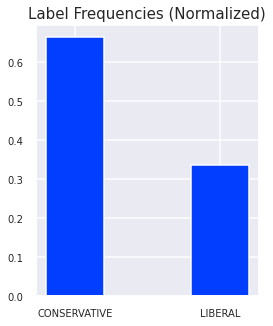

In [59]:
plot_label_frequencies(corpus, 
                          document_col="tokens",
                          label_col="stance",
                          figsize=(4,5),
                          barwidth=0.4,
                          filepath="images/corpus-statistics/stance-frequencies.png")

##### *C.3.1.2 - `issue`*

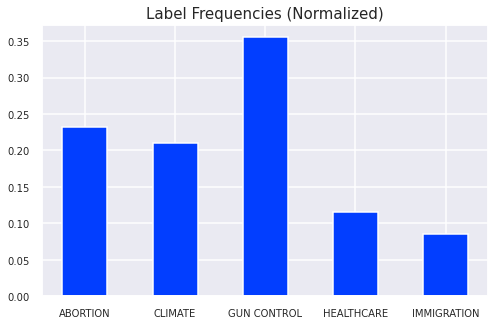

In [60]:
plot_label_frequencies(corpus, 
                          document_col="tokens",
                          label_col="issue",
                          figsize=(8,5),
                          filepath="images/corpus-statistics/issue-frequencies.png")

### *C.3.2 - Average Length of Tokenized Document*

In [61]:
average_token_length(corpus, document_col="tokens")

13.82

> The average length of the normalized Corpus was $13.82\ \text{tokens}/\text{document}$, which implies a couple of sentences worth of tokens, on average, made it through the text normalization process. Since there is only an average of $13$-$14$ tokens per normalized comment, collecting $N$-grams larger than bigrams isn't likely to provide much additional benefit. For this reason, unigrams and bigrams were considered during the vectorization process (see *__Section C.3__*).

### *C.3.3 - Ratio of Corpus Size to Document Size*

In [62]:
int(corpus.shape[0] / average_token_length(corpus, document_col="tokens"))

4479

### *C.3.4 - Document Frequencies by Label*

> The following plots list the top $15$ most frequently occurring words for each label in the Corpus. Note that the ***document frequency*** of a certain word refers to the number of documents (i.e. comments) in the corpus containing that word. 

##### *C.3.3.1 - `stance`*

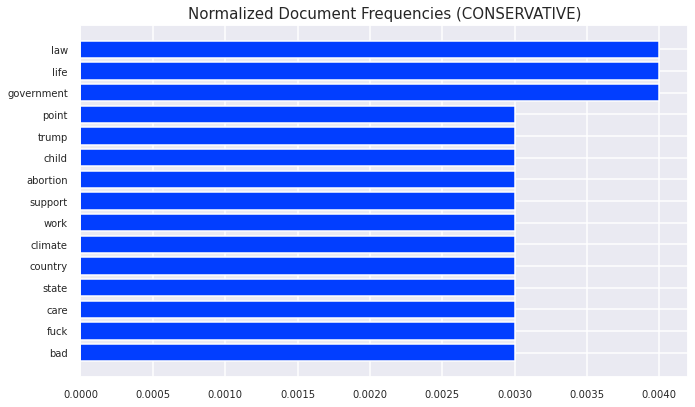

In [63]:
plot_document_frequencies(corpus, 
                              document_col="tokens",
                              label_col="stance",
                              label_name="CONSERVATIVE", 
                              N=15, 
                              figsize=(10,6), 
                              filepath="images/corpus-statistics/CONSERVATIVE-document-frequencies.png")

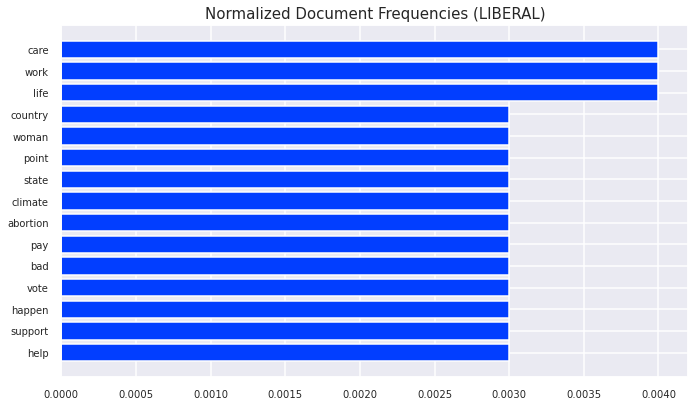

In [64]:
plot_document_frequencies(corpus, 
                              document_col="tokens",
                              label_col="stance",
                              label_name="LIBERAL", 
                              N=15, 
                              figsize=(10,6), 
                              filepath="images/corpus-statistics/LIBERAL-document-frequencies.png")

##### *C.3.3.2 - `issue`*

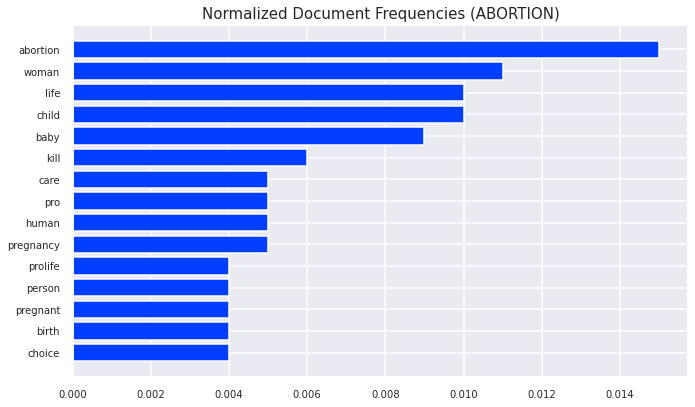

In [65]:
plot_document_frequencies(corpus, 
                              document_col="tokens",
                              label_col="issue",
                              label_name="ABORTION", 
                              N=15, 
                              figsize=(10,6), 
                              filepath="images/corpus-statistics/ABORTION-document-frequencies.png")

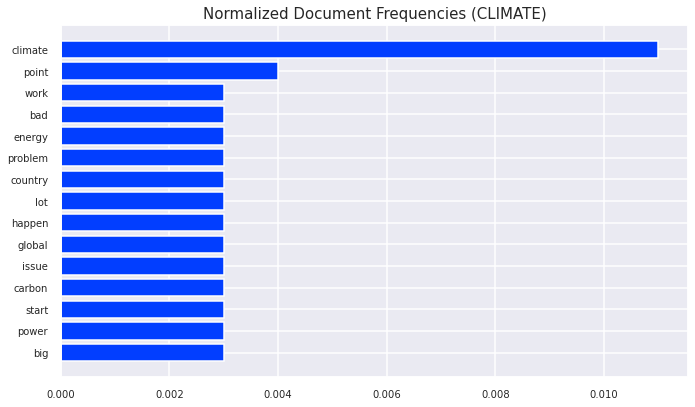

In [66]:
plot_document_frequencies(corpus, 
                              document_col="tokens",
                              label_col="issue",
                              label_name="CLIMATE", 
                              N=15, 
                              figsize=(10,6), 
                              filepath="images/corpus-statistics/CLIMATE-document-frequencies.png")

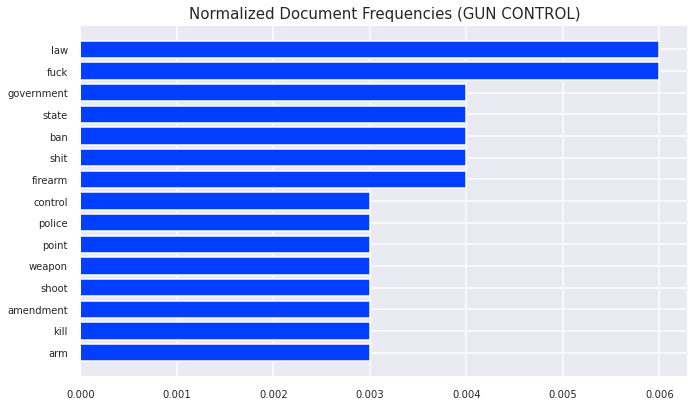

In [67]:
plot_document_frequencies(corpus, 
                              document_col="tokens",
                              label_col="issue",
                              label_name="GUN CONTROL", 
                              N=15, 
                              figsize=(10,6), 
                              filepath="images/corpus-statistics/GUN CONTROL-document-frequencies.png")

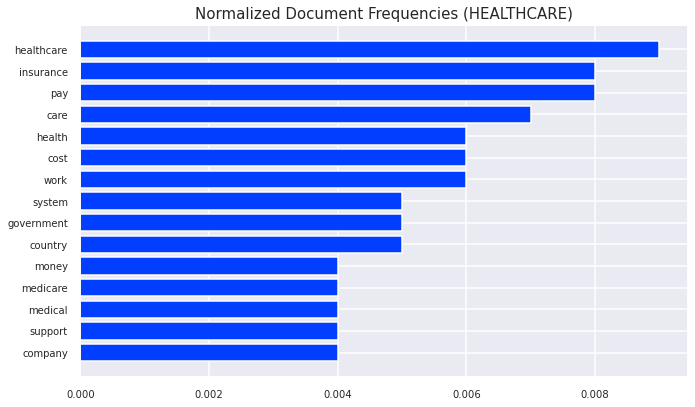

In [68]:
plot_document_frequencies(corpus, 
                              document_col="tokens",
                              label_col="issue",
                              label_name="HEALTHCARE", 
                              N=15, 
                              figsize=(10,6), 
                              filepath="images/corpus-statistics/HEALTHCARE-document-frequencies.png")

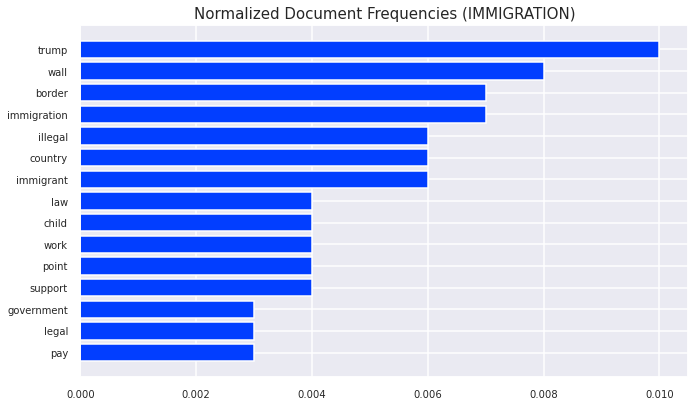

In [69]:
plot_document_frequencies(corpus, 
                              document_col="tokens",
                              label_col="issue",
                              label_name="IMMIGRATION", 
                              N=15, 
                              figsize=(10,6), 
                              filepath="images/corpus-statistics/IMMIGRATION-document-frequencies.png")

The plots above indicate that:

* words such as __`good`__, __`love`__, __`well`__, and __`laugh`__ are more prevalent in tweets with a __`POSITIVE`__ sentiment 
* words such as __`start`__, __`leave`__, __`eat`__, and __`rain`__ are more prevalent in tweets with a __`NEUTRAL`__ sentiment 
* words such as __`bad`__, __`sad`__, __`hate`__, and __`miss`__ are more prevalent in tweets with a __`NEGATIVE`__ sentiment 

> As these words would typically be associated with those sentiments, the plots confirm that the *Training Corpus* was indeed labeled accurately.

## C.4 - Extracting the Trainining, Validation, and Test Sets

> The Corpus was randomly split into a Training, Validation, and Test Set. The Training Set contained $70\%$ of the Corpus samples, while the remaining samples were split evenly between the Validation and Test Sets ($15\%$ each). 

In [70]:
if isinstance(corpus["tokens"][0], list):
    corpus["tokens"] = corpus["tokens"].apply(' '.join)

In [71]:
X = corpus["tokens"]
y = corpus[["issue", "stance", "quality"]]

In [72]:
X_train, X_validate_and_test, Y_train, Y_validate_and_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_validate, X_test, Y_validate, Y_test = train_test_split(X_validate_and_test, Y_validate_and_test, test_size=0.50, random_state=42)

In [73]:
print(f"X_train:\t({' x '.join(map(str, X_train.shape))})")
print(f"Y_train:\t({' x '.join(map(str, Y_train.shape))})\n")
print(f"X_validate:\t({' x '.join(map(str, X_validate.shape))})")
print(f"Y_validate:\t({' x '.join(map(str, Y_validate.shape))})\n")
print(f"X_test:\t\t({' x '.join(map(str, X_test.shape))})")
print(f"Y_test:\t\t({' x '.join(map(str, Y_test.shape))})")

X_train:	(43330)
Y_train:	(43330 x 3)

X_validate:	(9285)
Y_validate:	(9285 x 3)

X_test:		(9285)
Y_test:		(9285 x 3)


## C.5 - Vectorizing the Training, Validation, and Test Sets

> The number of features used during the vectorization process was $15,000$. The Training, Validation, and Test Set were vectorized via the `keras.layers.TextVectorization` layer, which was used to perform $2$ types of vectorization: integer encoding and multi-hot encoding with TF-IDF weighting.  Only unigrams were considered during integer encoding and unigrams + bigrams were considered during the multi-hot encoding with TF-IDF weighting.

In [74]:
MAX_FEATURES = 15_000
MAX_DOCUMENT_LENGTH = max(len(token_list) for token_list in corpus.tokens.str.split())

### *C.5.1 - Integer Encoding*

> The `tensorflow.keras.layers.TextVectorization` layer was adapted to the Training Set and then used to transform the Training, Validation, and Test Set into a collection of vectors comprised of integer indexed tokens.

In [75]:
integer_encoder = TextVectorization(max_tokens=MAX_FEATURES,
                                        standardize=None,
                                        split="whitespace",
                                        ngrams=1,
                                        output_mode="int",
                                        output_sequence_length=MAX_DOCUMENT_LENGTH,
                                        pad_to_max_tokens=False)

2022-09-26 16:44:35.914994: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-26 16:44:35.939454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-26 16:44:35.940079: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-26 16:44:35.940903: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [76]:
with tf.device("CPU"):
    integer_encoder.adapt(X_train.values)

In [77]:
X_train_IE = integer_encoder(X_train.values)
X_train_IE

<tf.Tensor: shape=(43330, 656), dtype=int64, numpy=
array([[ 1673,  1159,   324, ...,     0,     0,     0],
       [ 3904,   544,   486, ...,     0,     0,     0],
       [10523,   703,   217, ...,     0,     0,     0],
       ...,
       [  673,   377,     0, ...,     0,     0,     0],
       [  178,     0,     0, ...,     0,     0,     0],
       [  607,  1150,  1812, ...,     0,     0,     0]])>

In [78]:
X_validate_IE = integer_encoder(X_validate.values)
X_validate_IE

<tf.Tensor: shape=(9285, 656), dtype=int64, numpy=
array([[  183,   374,   209, ...,     0,     0,     0],
       [  947,  2723,     0, ...,     0,     0,     0],
       [ 3357,   157,    31, ...,     0,     0,     0],
       ...,
       [  173,    27,  4433, ...,     0,     0,     0],
       [  642,  1474,     0, ...,     0,     0,     0],
       [  533,    45, 12528, ...,     0,     0,     0]])>

In [79]:
X_test_IE = integer_encoder(X_test.values)
X_test_IE

<tf.Tensor: shape=(9285, 656), dtype=int64, numpy=
array([[   31,  1878,  4143, ...,     0,     0,     0],
       [  788,   458,   363, ...,     0,     0,     0],
       [    1,  1394,  2178, ...,     0,     0,     0],
       ...,
       [    6,    18,   474, ...,     0,     0,     0],
       [   33,   172,  1038, ...,     0,     0,     0],
       [ 2380, 12872,   903, ...,     0,     0,     0]])>

In [80]:
print(f"X_train_IE:\t({' x '.join(map(str, X_train_IE.shape))})")
print(f"X_validate_IE:\t({' x '.join(map(str, X_validate_IE.shape))})")
print(f"X_test_IE:\t({' x '.join(map(str, X_test_IE.shape))})")

X_train_IE:	(43330 x 656)
X_validate_IE:	(9285 x 656)
X_test_IE:	(9285 x 656)


### *C.5.2 - Multi-Hot Encoding with TF-IDF Weighting*

> The `tensorflow.keras.layers.TextVectorization` layer was adapted to the Training Set and then used to transform the Training, Validation, and Test Set into a collection of multi-hot vectors comprised of TF-IDF weighted tokens.

In [81]:
tv = TextVectorization(max_tokens=MAX_FEATURES,
                                        standardize=None,
                                        split="whitespace",
                                        ngrams=2,
                                        output_mode="tf-idf",
                                        pad_to_max_tokens=False)

In [82]:
with tf.device("CPU"):
    tv.adapt(X_train.values)

In [83]:
with tf.device("CPU"):
    X_train_TV = tv(X_train.values)
X_train_TV

2022-09-26 16:44:47.026358: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2599800000 exceeds 10% of free system memory.
2022-09-26 16:44:47.316823: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2599800000 exceeds 10% of free system memory.


<tf.Tensor: shape=(43330, 15000), dtype=float32, numpy=
array([[ 31.783411 ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       [182.75461  ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       [135.0795   ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       ...,
       [  7.9458528,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       [373.45508  ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ]], dtype=float32)>

In [84]:
with tf.device("CPU"):
    X_validate_TV = tv(X_validate.values)
X_validate_TV

<tf.Tensor: shape=(9285, 15000), dtype=float32, numpy=
array([[15.8917055,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 7.9458528,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [15.8917055,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [ 7.9458528,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 7.9458528,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [39.729263 ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ]], dtype=float32)>

In [85]:
with tf.device("CPU"):
    X_test_TV = tv(X_test.values)
X_test_TV

<tf.Tensor: shape=(9285, 15000), dtype=float32, numpy=
array([[174.80876  ,   0.       ,   3.1754699, ...,   0.       ,
          0.       ,   0.       ],
       [ 47.675117 ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       [ 47.675117 ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       ...,
       [ 31.783411 ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       [ 71.51267  ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       [ 95.350235 ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ]], dtype=float32)>

In [86]:
print(f"X_train_TV:\t({' x '.join(map(str, X_train_TV.shape))})")
print(f"X_validate_TV:\t({' x '.join(map(str, X_validate_TV.shape))})")
print(f"X_test_TV:\t({' x '.join(map(str, X_test_TV.shape))})")

X_train_TV:	(43330 x 15000)
X_validate_TV:	(9285 x 15000)
X_test_TV:	(9285 x 15000)


## C.6 - Encoding the Training, Validation, and Test Labels

### *C.6.1 - `stance`*

In [87]:
lb_stance = LabelBinarizer()

In [88]:
y_train_stance = lb_stance.fit_transform(Y_train.stance)
y_train_stance

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [1]])

In [89]:
y_validate_stance = lb_stance.transform(Y_validate.stance)
y_validate_stance

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [90]:
y_test_stance = lb_stance.transform(Y_test.stance)
y_test_stance

array([[0],
       [1],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [91]:
print(f"y_train_stance:\t\t({' x '.join(map(str, y_train_stance.shape))})")
print(f"y_validate_stance:\t({' x '.join(map(str, y_validate_stance.shape))})")
print(f"y_test_stance:\t\t({' x '.join(map(str, y_test_stance.shape))})")

y_train_stance:		(43330 x 1)
y_validate_stance:	(9285 x 1)
y_test_stance:		(9285 x 1)


### *C.6.2 - `issue`*

In [92]:
lb_issue = LabelBinarizer()

In [93]:
y_train_issue = lb_issue.fit_transform(Y_train.issue)
y_train_issue

array([[1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0]])

In [94]:
y_validate_issue = lb_issue.transform(Y_validate.issue)
y_validate_issue

array([[0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]])

In [95]:
y_test_issue = lb_issue.transform(Y_test.issue)
y_test_issue

array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       ...,
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1]])

In [96]:
print(f"y_train_issue:\t\t({' x '.join(map(str, y_train_issue.shape))})")
print(f"y_validate_issue:\t({' x '.join(map(str, y_validate_issue.shape))})")
print(f"y_test_issue:\t\t({' x '.join(map(str, y_test_issue.shape))})")

y_train_issue:		(43330 x 5)
y_validate_issue:	(9285 x 5)
y_test_issue:		(9285 x 5)


## C.7 - Balancing the Training Labels

In [97]:
issue_weights = compute_sample_weight("balanced", Y_train["issue"])
issue_weights


array([0.85793486, 1.69988231, 1.69988231, ..., 0.56610922, 0.56610922,
       0.56610922])

In [98]:
stance_weights = compute_sample_weight("balanced", Y_train["stance"])
stance_weights

array([0.75535179, 0.75535179, 1.47904151, ..., 0.75535179, 0.75535179,
       1.47904151])

## C.8 - Weighting the Training Samples with the `quality` Feature

In [99]:
issue_weights = (issue_weights * Y_train["quality"]).to_numpy()
issue_weights

array([2.04728511, 1.91644475, 1.69988231, ..., 0.57526483, 0.63500298,
       0.68286458])

In [100]:
stance_weights = (issue_weights * Y_train["quality"]).to_numpy()
stance_weights

array([4.88542492, 2.16059693, 1.69988231, ..., 0.58456851, 0.7122809 ,
       0.82369975])

# D. *Modeling*

> A series of Dense Neural Networks containing one or more hidden layers, were trained on the Training Set. The inputs to these models were the TF-IDF weighted multi-hot vectors produced by the `TextVectorization` layer in ***Section C.5.2*** (`X_train_TV`, `X_validate_TV`, and `X_test_TV`). The main parameters being altered were: the architecture (the number and size of hidden layers) and the number/strength of dropout layers. 

## D.1 - Scoring

The $F_1\text{-Score}$ was the primary metric by which the models were evaluated. This score takes into account both recall ($R$) and precision ($P$) - if one of these metrics suffers, it will be reflected in the $F_1\text{-Score}$.

The formula for the $F_1\text{-Score}$ is:
> $$ F_1 = 2(\dfrac{1}{R} + \dfrac{1}{P})$$

In [149]:
VOCABULARY_SIZE = MAX_FEATURES
NUM_ISSUES = 5

In [150]:
y_train_issue_true = lb_issue.inverse_transform(y_train_issue)
y_validate_issue_true = lb_issue.inverse_transform(y_validate_issue)

y_train_stance_true = lb_stance.inverse_transform(y_train_stance)
y_validate_stance_true = lb_stance.inverse_transform(y_validate_stance)

In [152]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

## D.2 - Dense Neural Network (DNN)

### *D.2.1 - Building and Training Various Architectures*

#### *`DNN 1`*

Epoch 1/100
339/339 [==============================] - 12s 34ms/step - loss: 2.5070 - issue_loss: 1.5365 - stance_loss: 0.9706 - issue_accuracy: 0.5177 - stance_accuracy: 0.6797 - val_loss: 1.6467 - val_issue_loss: 1.0366 - val_stance_loss: 0.6100 - val_issue_accuracy: 0.6340 - val_stance_accuracy: 0.7037
Epoch 2/100
339/339 [==============================] - 11s 33ms/step - loss: 1.8048 - issue_loss: 1.0149 - stance_loss: 0.7899 - issue_accuracy: 0.7000 - stance_accuracy: 0.7312 - val_loss: 1.5398 - val_issue_loss: 0.9373 - val_stance_loss: 0.6025 - val_issue_accuracy: 0.6640 - val_stance_accuracy: 0.7081
Epoch 3/100
339/339 [==============================] - 10s 31ms/step - loss: 1.3825 - issue_loss: 0.7474 - stance_loss: 0.6351 - issue_accuracy: 0.7686 - stance_accuracy: 0.7762 - val_loss: 1.5536 - val_issue_loss: 0.9435 - val_stance_loss: 0.6101 - val_issue_accuracy: 0.6573 - val_stance_accuracy: 0.7029
Epoch 4/100
339/339 [==============================] - 11s 33ms/step - loss: 1.

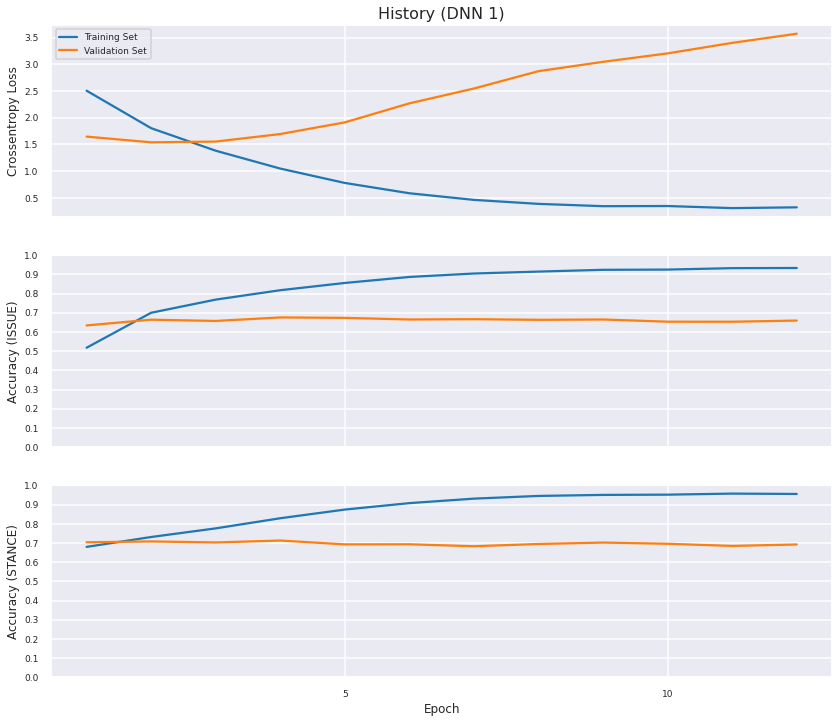

In [154]:
MODEL_NAME = "dnn_1"

comment = Input(shape=(VOCABULARY_SIZE,), name="comment") 

x = Dense(64, activation="relu")(comment)
x = Dense(32, activation="relu")(x)
x = Dense(16, activation="relu")(x)
x = Dense(8, activation="relu")(x)

stance = Dense(1, activation="sigmoid", name="stance")(x)
issue = Dense(NUM_ISSUES, activation="softmax", name="issue")(x)

dnn = Model(inputs=comment, outputs=[issue, stance], name=MODEL_NAME)

dnn.compile(optimizer="Adam", 
                loss={"issue": "categorical_crossentropy", "stance": "binary_crossentropy"},
                metrics="accuracy")

checkpoint = ModelCheckpoint(filepath=f"models/{''.join(MODEL_NAME.split('_'))}.h5",
                                save_best_only=True,
                                monitor="val_loss",
                                mode="min")
with tf.device("GPU"):
    history = dnn.fit(X_train_TV, 
                       {"issue": y_train_issue, "stance": y_train_stance}, 
                       batch_size=128,
                       epochs=100,        
                       validation_data=(X_validate_TV, {"issue": y_validate_issue, "stance": y_validate_stance}),
                       validation_batch_size=32,
                       sample_weight={"issue": issue_weights, "stance": stance_weights}, 
                       callbacks=[early_stopping, checkpoint],
                       verbose=1)

plot_history(MODEL_NAME, 
              history.history, 
              filepath=f"images/{''.join(MODEL_NAME.split('_'))}/history.png",
              figsize=(14,12))

#### *`DNN 2`*

Epoch 1/100
339/339 [==============================] - 14s 38ms/step - loss: 2.7143 - issue_loss: 1.6744 - stance_loss: 1.0399 - issue_accuracy: 0.3709 - stance_accuracy: 0.6421 - val_loss: 1.7709 - val_issue_loss: 1.1496 - val_stance_loss: 0.6213 - val_issue_accuracy: 0.5833 - val_stance_accuracy: 0.6644
Epoch 2/100
339/339 [==============================] - 11s 33ms/step - loss: 2.1804 - issue_loss: 1.2165 - stance_loss: 0.9640 - issue_accuracy: 0.6188 - stance_accuracy: 0.6631 - val_loss: 1.5730 - val_issue_loss: 0.9549 - val_stance_loss: 0.6181 - val_issue_accuracy: 0.6541 - val_stance_accuracy: 0.6613
Epoch 3/100
339/339 [==============================] - 11s 34ms/step - loss: 1.8635 - issue_loss: 0.9549 - stance_loss: 0.9086 - issue_accuracy: 0.7044 - stance_accuracy: 0.6783 - val_loss: 1.5265 - val_issue_loss: 0.9181 - val_stance_loss: 0.6084 - val_issue_accuracy: 0.6660 - val_stance_accuracy: 0.6912
Epoch 4/100
339/339 [==============================] - 12s 35ms/step - loss: 1.

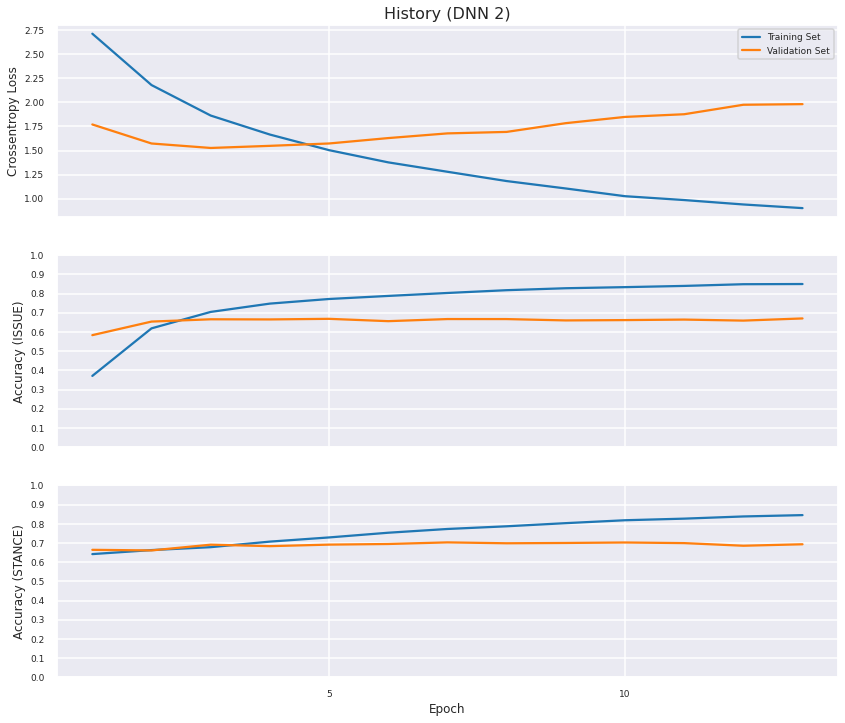

In [ ]:
MODEL_NAME = "dnn_2"

comment = Input(shape=(VOCABULARY_SIZE,), name="comment") 

x = Dense(64, activation="relu")(comment)
x = Dropout(0.3)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(8, activation="relu")(x)

stance = Dense(1, activation="sigmoid", name="stance")(x)
issue = Dense(NUM_ISSUES, activation="softmax", name="issue")(x)

dnn = Model(inputs=comment, outputs=[issue, stance], name=MODEL_NAME)

dnn.compile(optimizer="Adam", 
                loss={"issue": "categorical_crossentropy", "stance": "binary_crossentropy"},
                metrics="accuracy")

checkpoint = ModelCheckpoint(filepath=f"models/{''.join(MODEL_NAME.split('_'))}.h5",
                                save_best_only=True,
                                monitor="val_loss",
                                mode="min")
with tf.device("GPU"):
    history = dnn.fit(X_train_TV, 
                       {"issue": y_train_issue, "stance": y_train_stance}, 
                       batch_size=128,
                       epochs=100,        
                       validation_data=(X_validate_TV, {"issue": y_validate_issue, "stance": y_validate_stance}),
                       validation_batch_size=32,
                       sample_weight={"issue": issue_weights, "stance": stance_weights}, 
                       callbacks=[early_stopping, checkpoint],
                       verbose=1)

plot_history(MODEL_NAME, 
              history.history, 
              filepath=f"images/{''.join(MODEL_NAME.split('_'))}/history.png",
              figsize=(14,12))

#### *`DNN 3`*

Epoch 1/100
339/339 [==============================] - 13s 37ms/step - loss: 2.8687 - issue_loss: 1.8295 - stance_loss: 1.0391 - issue_accuracy: 0.3106 - stance_accuracy: 0.6565 - val_loss: 1.8999 - val_issue_loss: 1.2887 - val_stance_loss: 0.6112 - val_issue_accuracy: 0.5935 - val_stance_accuracy: 0.6710
Epoch 2/100
339/339 [==============================] - 12s 34ms/step - loss: 2.4050 - issue_loss: 1.4237 - stance_loss: 0.9813 - issue_accuracy: 0.5349 - stance_accuracy: 0.6631 - val_loss: 1.5910 - val_issue_loss: 0.9806 - val_stance_loss: 0.6104 - val_issue_accuracy: 0.6624 - val_stance_accuracy: 0.6870
Epoch 3/100
339/339 [==============================] - 11s 34ms/step - loss: 2.0879 - issue_loss: 1.1645 - stance_loss: 0.9235 - issue_accuracy: 0.6303 - stance_accuracy: 0.6760 - val_loss: 1.5312 - val_issue_loss: 0.9212 - val_stance_loss: 0.6100 - val_issue_accuracy: 0.6635 - val_stance_accuracy: 0.6688
Epoch 4/100
339/339 [==============================] - 12s 35ms/step - loss: 1.

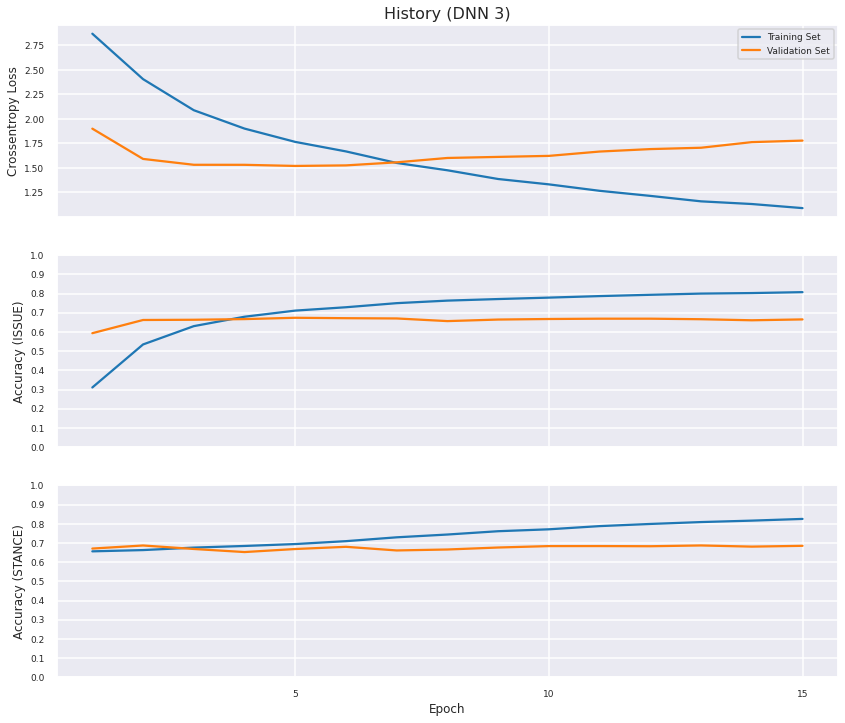

In [ ]:
MODEL_NAME = "dnn_3"

comment = Input(shape=(VOCABULARY_SIZE,), name="comment") 

x = Dense(64, activation="relu")(comment)
x = Dropout(0.4)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(8, activation="relu")(x)

stance = Dense(1, activation="sigmoid", name="stance")(x)
issue = Dense(NUM_ISSUES, activation="softmax", name="issue")(x)

dnn = Model(inputs=comment, outputs=[issue, stance], name=MODEL_NAME)

dnn.compile(optimizer="Adam", 
                loss={"issue": "categorical_crossentropy", "stance": "binary_crossentropy"},
                metrics="accuracy")

checkpoint = ModelCheckpoint(filepath=f"models/{''.join(MODEL_NAME.split('_'))}.h5",
                                save_best_only=True,
                                monitor="val_loss",
                                mode="min")
with tf.device("GPU"):
    history = dnn.fit(X_train_TV, 
                       {"issue": y_train_issue, "stance": y_train_stance}, 
                       batch_size=128,
                       epochs=100,        
                       validation_data=(X_validate_TV, {"issue": y_validate_issue, "stance": y_validate_stance}),
                       validation_batch_size=32,
                       sample_weight={"issue": issue_weights, "stance": stance_weights}, 
                       callbacks=[early_stopping, checkpoint],
                       verbose=1)

plot_history(MODEL_NAME, 
              history.history, 
              filepath=f"images/{''.join(MODEL_NAME.split('_'))}/history.png",
              figsize=(14,12))

#### *`DNN 4`*

Epoch 1/100
339/339 [==============================] - 13s 37ms/step - loss: 2.9612 - issue_loss: 1.8955 - stance_loss: 1.0657 - issue_accuracy: 0.3136 - stance_accuracy: 0.6443 - val_loss: 2.0943 - val_issue_loss: 1.4665 - val_stance_loss: 0.6279 - val_issue_accuracy: 0.4907 - val_stance_accuracy: 0.6759
Epoch 2/100
339/339 [==============================] - 12s 35ms/step - loss: 2.7223 - issue_loss: 1.7081 - stance_loss: 1.0143 - issue_accuracy: 0.4724 - stance_accuracy: 0.6730 - val_loss: 1.8341 - val_issue_loss: 1.2353 - val_stance_loss: 0.5988 - val_issue_accuracy: 0.6117 - val_stance_accuracy: 0.6967
Epoch 3/100
339/339 [==============================] - 12s 34ms/step - loss: 2.4743 - issue_loss: 1.4964 - stance_loss: 0.9779 - issue_accuracy: 0.5394 - stance_accuracy: 0.6822 - val_loss: 1.6554 - val_issue_loss: 1.0672 - val_stance_loss: 0.5883 - val_issue_accuracy: 0.6400 - val_stance_accuracy: 0.7005
Epoch 4/100
339/339 [==============================] - 12s 34ms/step - loss: 2.

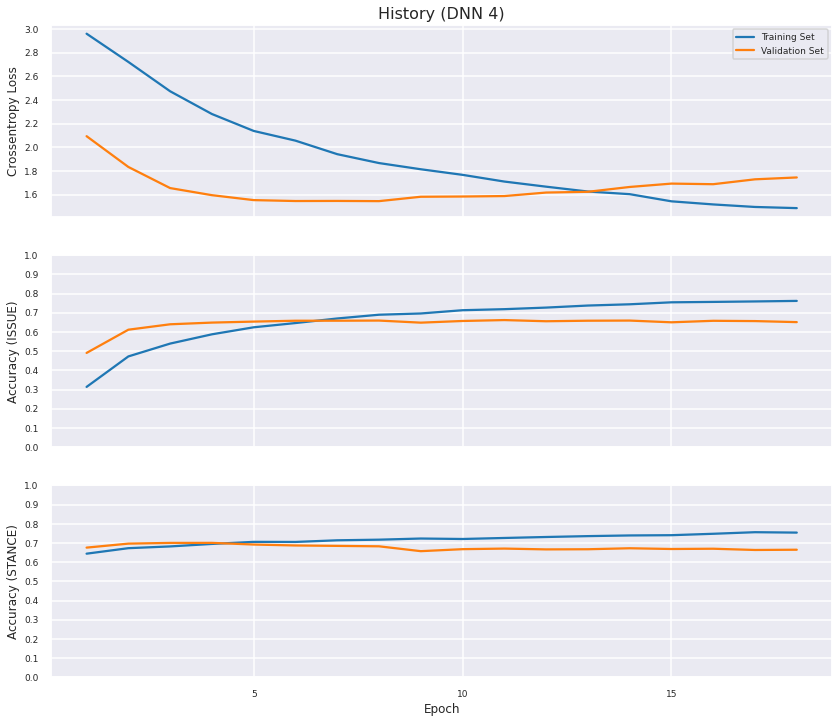

In [ ]:
MODEL_NAME = "dnn_4"

comment = Input(shape=(VOCABULARY_SIZE,), name="comment") 

x = Dense(64, activation="relu")(comment)
x = Dropout(0.5)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(8, activation="relu")(x)

stance = Dense(1, activation="sigmoid", name="stance")(x)
issue = Dense(NUM_ISSUES, activation="softmax", name="issue")(x)

dnn = Model(inputs=comment, outputs=[issue, stance], name=MODEL_NAME)

dnn.compile(optimizer="Adam", 
                loss={"issue": "categorical_crossentropy", "stance": "binary_crossentropy"},
                metrics="accuracy")

checkpoint = ModelCheckpoint(filepath=f"models/{''.join(MODEL_NAME.split('_'))}.h5",
                                save_best_only=True,
                                monitor="val_loss",
                                mode="min")
with tf.device("GPU"):
    history = dnn.fit(X_train_TV, 
                       {"issue": y_train_issue, "stance": y_train_stance}, 
                       batch_size=128,
                       epochs=100,        
                       validation_data=(X_validate_TV, {"issue": y_validate_issue, "stance": y_validate_stance}),
                       validation_batch_size=32,
                       sample_weight={"issue": issue_weights, "stance": stance_weights}, 
                       callbacks=[early_stopping, checkpoint],
                       verbose=1)

plot_history(MODEL_NAME, 
              history.history, 
              filepath=f"images/{''.join(MODEL_NAME.split('_'))}/history.png",
              figsize=(14,12))

#### *`DNN 5`*

Epoch 1/100
339/339 [==============================] - 14s 38ms/step - loss: 2.8231 - issue_loss: 1.7780 - stance_loss: 1.0450 - issue_accuracy: 0.3859 - stance_accuracy: 0.6581 - val_loss: 1.7883 - val_issue_loss: 1.1784 - val_stance_loss: 0.6099 - val_issue_accuracy: 0.6108 - val_stance_accuracy: 0.6915
Epoch 2/100
339/339 [==============================] - 12s 37ms/step - loss: 2.2359 - issue_loss: 1.3010 - stance_loss: 0.9349 - issue_accuracy: 0.6089 - stance_accuracy: 0.6890 - val_loss: 1.5687 - val_issue_loss: 0.9729 - val_stance_loss: 0.5959 - val_issue_accuracy: 0.6562 - val_stance_accuracy: 0.6985
Epoch 3/100
339/339 [==============================] - 12s 36ms/step - loss: 1.8803 - issue_loss: 1.0419 - stance_loss: 0.8384 - issue_accuracy: 0.6837 - stance_accuracy: 0.7157 - val_loss: 1.5088 - val_issue_loss: 0.9182 - val_stance_loss: 0.5905 - val_issue_accuracy: 0.6725 - val_stance_accuracy: 0.7037
Epoch 4/100
339/339 [==============================] - 12s 36ms/step - loss: 1.

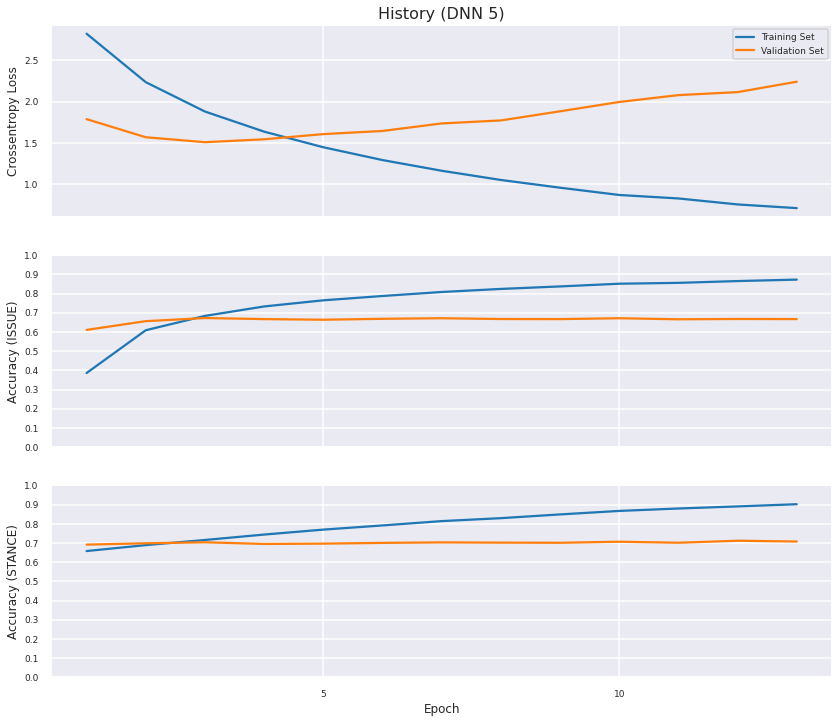

In [ ]:
MODEL_NAME = "dnn_5"

comment = Input(shape=(VOCABULARY_SIZE,), name="comment") 

x = Dense(128, activation="relu")(comment)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(8, activation="relu")(x)

stance = Dense(1, activation="sigmoid", name="stance")(x)
issue = Dense(NUM_ISSUES, activation="softmax", name="issue")(x)

dnn = Model(inputs=comment, outputs=[issue, stance], name=MODEL_NAME)

dnn.compile(optimizer="Adam", 
                loss={"issue": "categorical_crossentropy", "stance": "binary_crossentropy"},
                metrics="accuracy")

checkpoint = ModelCheckpoint(filepath=f"models/{''.join(MODEL_NAME.split('_'))}.h5",
                                save_best_only=True,
                                monitor="val_loss",
                                mode="min")
with tf.device("GPU"):
    history = dnn.fit(X_train_TV, 
                       {"issue": y_train_issue, "stance": y_train_stance}, 
                       batch_size=128,
                       epochs=100,        
                       validation_data=(X_validate_TV, {"issue": y_validate_issue, "stance": y_validate_stance}),
                       validation_batch_size=32,
                       sample_weight={"issue": issue_weights, "stance": stance_weights}, 
                       callbacks=[early_stopping, checkpoint],
                       verbose=1)

plot_history(MODEL_NAME, 
              history.history, 
              filepath=f"images/{''.join(MODEL_NAME.split('_'))}/history.png",
              figsize=(14,12))

### *D.2.2 - Model Validation*

#### *`DNN 1`*

In [287]:
MODEL_NAME = "dnn_1"

loaded_model = load_model(f"models/{''.join(MODEL_NAME.split('_'))}.h5")

y_train_pred = loaded_model.predict(X_train_TV)
y_validate_pred = loaded_model.predict(X_validate_TV)

y_train_issue_pred = lb_issue.inverse_transform(y_train_pred[0])
y_validate_issue_pred = lb_issue.inverse_transform(y_validate_pred[0])

y_train_stance_pred = lb_stance.inverse_transform(y_train_pred[1])
y_validate_stance_pred = lb_stance.inverse_transform(y_validate_pred[1])

291/291 [==============================] - 2s 5ms/step


##### `ISSUE`

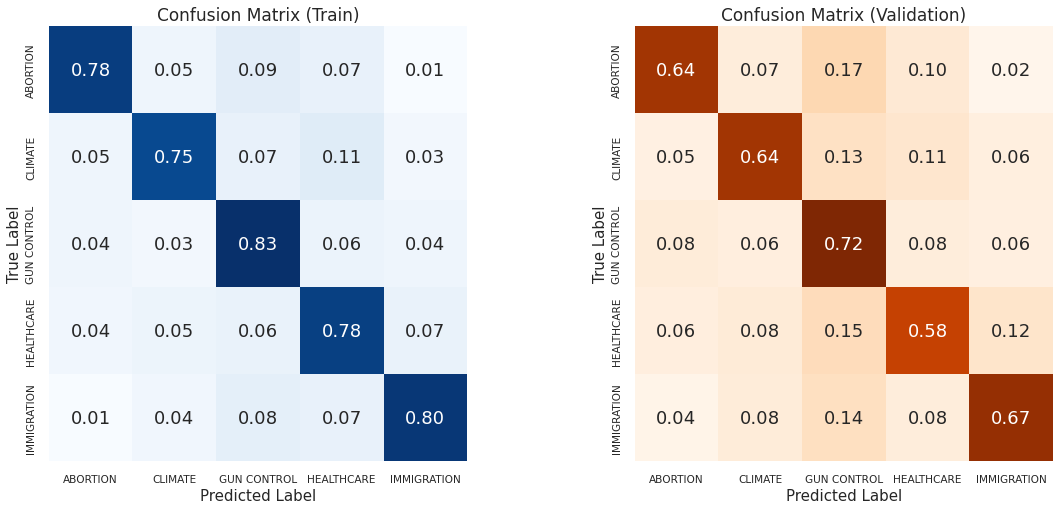

In [288]:
plot_validation_confusion_matrices(y_train_issue_true, 
                                        y_train_issue_pred, 
                                        y_validate_issue_true, 
                                        y_validate_issue_pred, 
                                        target_names=lb_issue.classes_, 
                                        normalize="true", 
                                        sample_weight=issue_weights,
                                        figsize=(18,8),
                                        filepath=f"images/{''.join(MODEL_NAME.split('_'))}/ISSUE-validation-confusion-matrices.png")

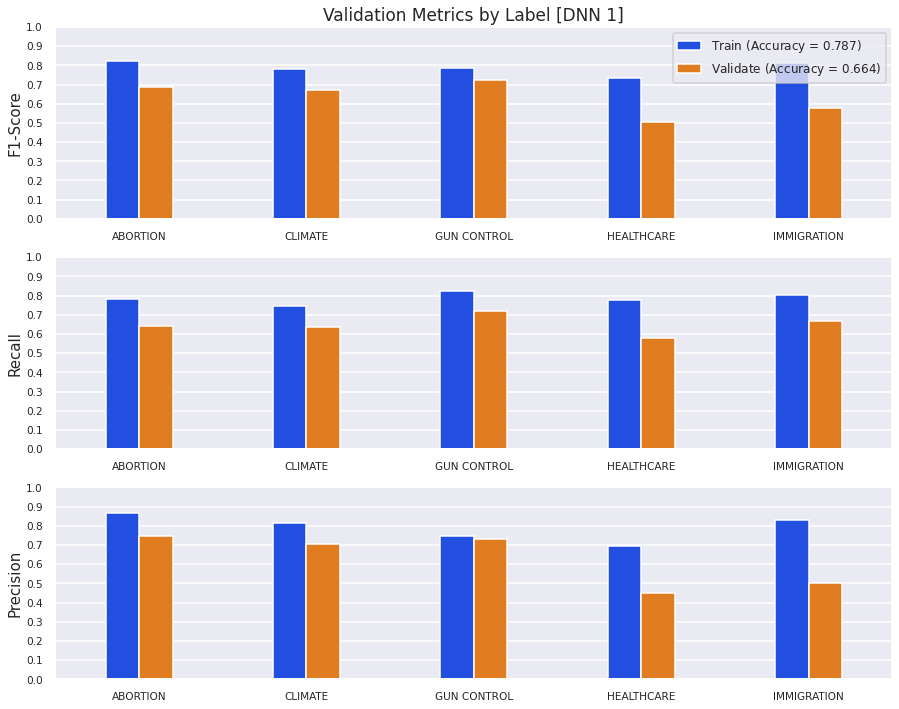

In [289]:
plot_multilabel_validation_metrics(y_train_issue_true, 
                                        y_train_issue_pred, 
                                        y_validate_issue_true, 
                                        y_validate_issue_pred, 
                                        score_names = ['f1-score', 'recall', 'precision'],
                                        score_labels=["F1-Score", "Recall", "Precision"],
                                        target_names=lb_issue.classes_,
                                        estimator_label=f"{' '.join(MODEL_NAME.split('_')).upper()}",
                                        sample_weight=issue_weights,
                                        mode="validate",
                                        filepath=f"images/{''.join(MODEL_NAME.split('_'))}/ISSUE-validation-metrics.png")

In [290]:
dnn1_val_metrics_issue = get_classification_metrics(y_validate_issue_true, 
                                                            y_validate_issue_pred, 
                                                            target_names=lb_issue.classes_)

dnn1_average_f1_score_issue = dnn1_val_metrics_issue.loc["F1-Score"]["Average"]
dnn1_average_f1_score_issue

0.633

##### `STANCE`

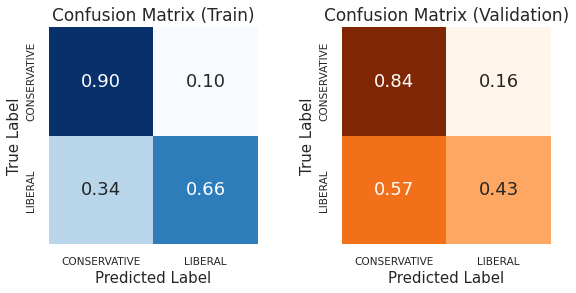

In [291]:
plot_validation_confusion_matrices(y_train_stance_true, 
                            y_train_stance_pred, 
                            y_validate_stance_true, 
                            y_validate_stance_pred, 
                            target_names=lb_stance.classes_, 
                            normalize="true", 
                            sample_weight=stance_weights,
                            figsize=(9,4),
                            filepath=f"images/{''.join(MODEL_NAME.split('_'))}/STANCE-validation-confusion-matrices.png")

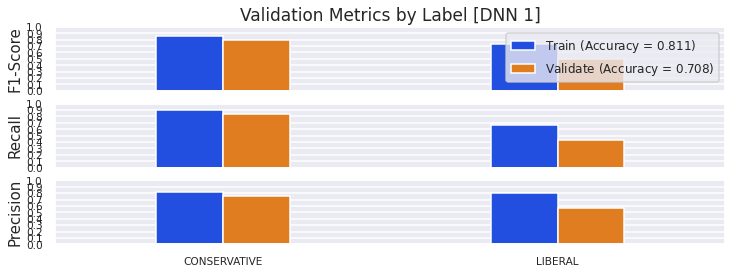

In [292]:
plot_multilabel_validation_metrics(y_train_stance_true, 
                                   y_train_stance_pred, 
                                   y_validate_stance_true, 
                                   y_validate_stance_pred, 
                                   score_names = ['f1-score', 'recall', 'precision'],
                                   score_labels=["F1-Score", "Recall", "Precision"],
                                   target_names=lb_stance.classes_,
                                   estimator_label=f"{' '.join(MODEL_NAME.split('_')).upper()}",                                  
                                   sample_weight=stance_weights,
                                   mode="validate",
                                   figsize=(12,4),
                                   filepath=f"images/{''.join(MODEL_NAME.split('_'))}/STANCE-validation-metrics.png")

In [293]:
dnn1_val_metrics_stance = get_classification_metrics(y_validate_stance_true, 
                                                            y_validate_stance_pred, 
                                                            target_names=lb_stance.classes_)

dnn1_average_f1_score_stance = dnn1_val_metrics_stance.loc["F1-Score"]["Average"]
dnn1_average_f1_score_stance

0.644

#### *`DNN 2`*

In [294]:
MODEL_NAME = "dnn_2"

loaded_model = load_model(f"models/{''.join(MODEL_NAME.split('_'))}.h5")

y_train_pred = loaded_model.predict(X_train_TV)
y_validate_pred = loaded_model.predict(X_validate_TV)

y_train_issue_pred = lb_issue.inverse_transform(y_train_pred[0])
y_validate_issue_pred = lb_issue.inverse_transform(y_validate_pred[0])

y_train_stance_pred = lb_stance.inverse_transform(y_train_pred[1])
y_validate_stance_pred = lb_stance.inverse_transform(y_validate_pred[1])

291/291 [==============================] - 2s 6ms/step


##### `ISSUE`

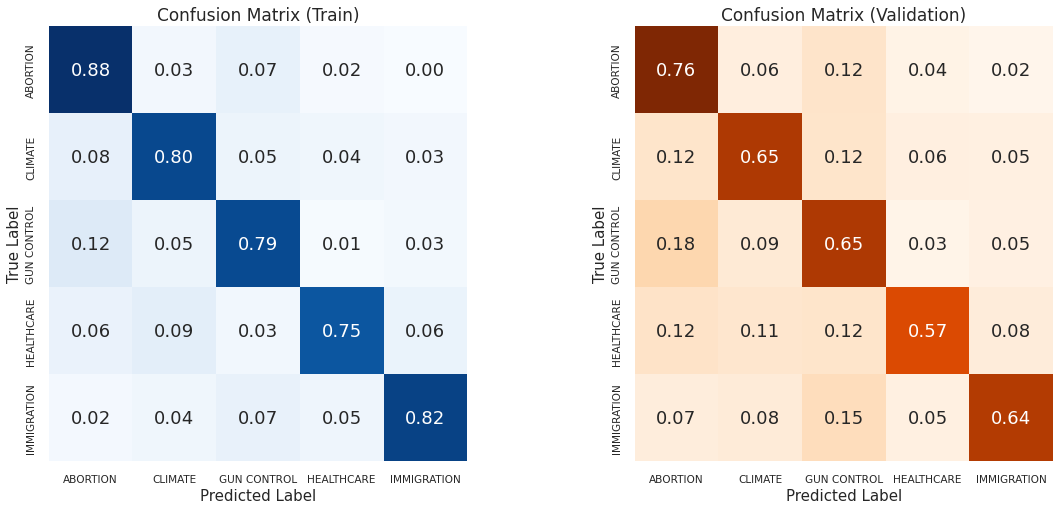

In [295]:
plot_validation_confusion_matrices(y_train_issue_true, 
                                        y_train_issue_pred, 
                                        y_validate_issue_true, 
                                        y_validate_issue_pred, 
                                        target_names=lb_issue.classes_, 
                                        normalize="true", 
                                        sample_weight=issue_weights,
                                        figsize=(18,8),
                                        filepath=f"images/{''.join(MODEL_NAME.split('_'))}/ISSUE-validation-confusion-matrices.png")

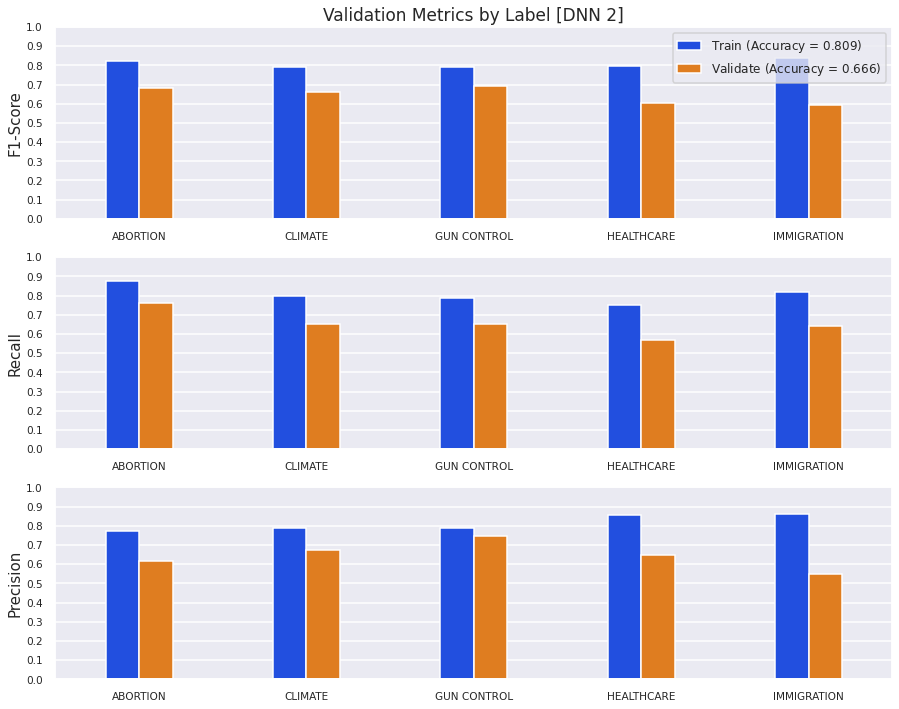

In [296]:
plot_multilabel_validation_metrics(y_train_issue_true, 
                                        y_train_issue_pred, 
                                        y_validate_issue_true, 
                                        y_validate_issue_pred, 
                                        score_names = ['f1-score', 'recall', 'precision'],
                                        score_labels=["F1-Score", "Recall", "Precision"],
                                        target_names=lb_issue.classes_,
                                        estimator_label=f"{' '.join(MODEL_NAME.split('_')).upper()}",
                                        sample_weight=issue_weights,
                                        mode="validate",
                                        filepath=f"images/{''.join(MODEL_NAME.split('_'))}/ISSUE-validation-metrics.png")

In [297]:
dnn2_val_metrics_issue = get_classification_metrics(y_validate_issue_true, 
                                                            y_validate_issue_pred, 
                                                            target_names=lb_issue.classes_)

dnn2_average_f1_score_issue = dnn2_val_metrics_issue.loc["F1-Score"]["Average"]
dnn2_average_f1_score_issue

0.647

##### `STANCE`

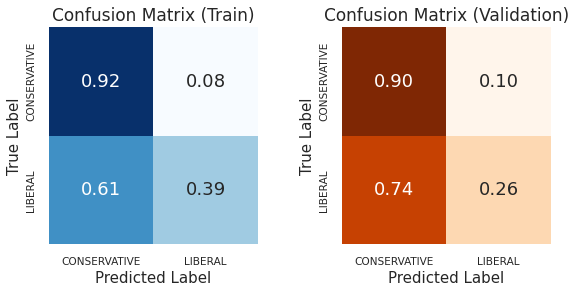

In [298]:
plot_validation_confusion_matrices(y_train_stance_true, 
                            y_train_stance_pred, 
                            y_validate_stance_true, 
                            y_validate_stance_pred, 
                            target_names=lb_stance.classes_, 
                            normalize="true", 
                            sample_weight=stance_weights,
                            figsize=(9,4),
                            filepath=f"images/{''.join(MODEL_NAME.split('_'))}/STANCE-validation-confusion-matrices.png")

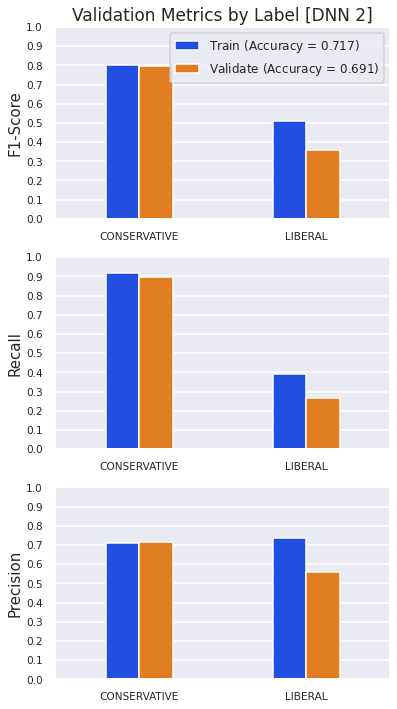

In [299]:
plot_multilabel_validation_metrics(y_train_stance_true, 
                                   y_train_stance_pred, 
                                   y_validate_stance_true, 
                                   y_validate_stance_pred, 
                                   score_names = ['f1-score', 'recall', 'precision'],
                                   score_labels=["F1-Score", "Recall", "Precision"],
                                   target_names=lb_stance.classes_,
                                   estimator_label=f"{' '.join(MODEL_NAME.split('_')).upper()}",                                   
                                   sample_weight=stance_weights,
                                   mode="validate",
                                   filepath=f"images/{''.join(MODEL_NAME.split('_'))}/STANCE-validation-metrics.png")

In [300]:
dnn2_val_metrics_stance = get_classification_metrics(y_validate_stance_true, 
                                                            y_validate_stance_pred, 
                                                            target_names=lb_stance.classes_)

dnn2_average_f1_score_stance = dnn2_val_metrics_stance.loc["F1-Score"]["Average"]
dnn2_average_f1_score_stance

0.578

#### *`DNN 3`*

In [301]:
MODEL_NAME = "dnn_3"

loaded_model = load_model(f"models/{''.join(MODEL_NAME.split('_'))}.h5")

y_train_pred = loaded_model.predict(X_train_TV)
y_validate_pred = loaded_model.predict(X_validate_TV)

y_train_issue_pred = lb_issue.inverse_transform(y_train_pred[0])
y_validate_issue_pred = lb_issue.inverse_transform(y_validate_pred[0])

y_train_stance_pred = lb_stance.inverse_transform(y_train_pred[1])
y_validate_stance_pred = lb_stance.inverse_transform(y_validate_pred[1])

291/291 [==============================] - 2s 6ms/step


##### `ISSUE`

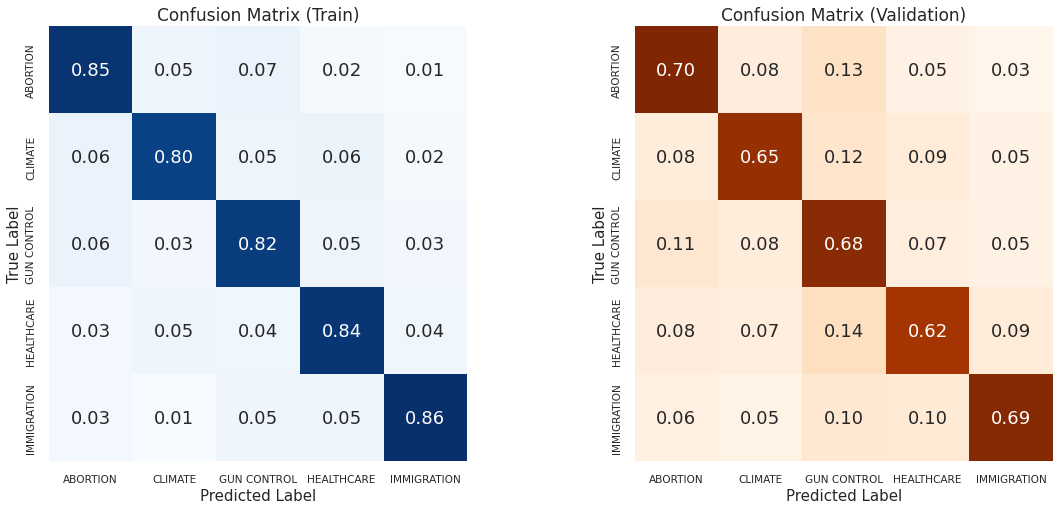

In [302]:
plot_validation_confusion_matrices(y_train_issue_true, 
                                        y_train_issue_pred, 
                                        y_validate_issue_true, 
                                        y_validate_issue_pred, 
                                        target_names=lb_issue.classes_, 
                                        normalize="true", 
                                        sample_weight=issue_weights,
                                        figsize=(18,8),
                                        filepath=f"images/{''.join(MODEL_NAME.split('_'))}/ISSUE-validation-confusion-matrices.png")

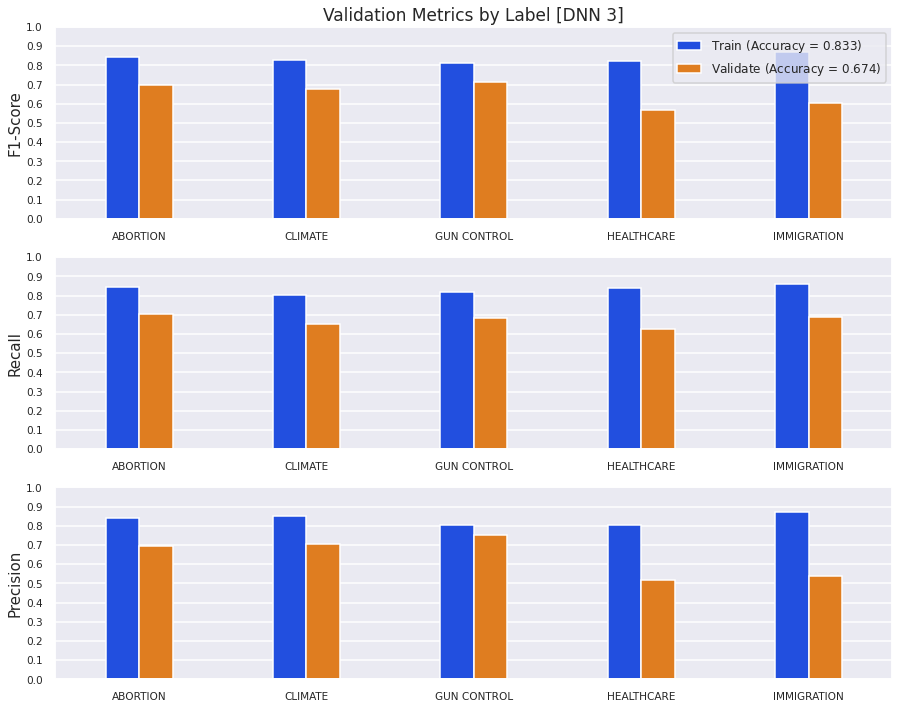

In [303]:
plot_multilabel_validation_metrics(y_train_issue_true, 
                                        y_train_issue_pred, 
                                        y_validate_issue_true, 
                                        y_validate_issue_pred, 
                                        score_names = ['f1-score', 'recall', 'precision'],
                                        score_labels=["F1-Score", "Recall", "Precision"],
                                        target_names=lb_issue.classes_,
                                        estimator_label=f"{' '.join(MODEL_NAME.split('_')).upper()}",
                                        sample_weight=issue_weights,
                                        mode="validate",
                                        filepath=f"images/{''.join(MODEL_NAME.split('_'))}/ISSUE-validation-metrics.png")

In [304]:
dnn3_val_metrics_issue = get_classification_metrics(y_validate_issue_true, 
                                                            y_validate_issue_pred, 
                                                            target_names=lb_issue.classes_)

dnn3_average_f1_score_issue = dnn3_val_metrics_issue.loc["F1-Score"]["Average"]
dnn3_average_f1_score_issue

0.651

##### `STANCE`

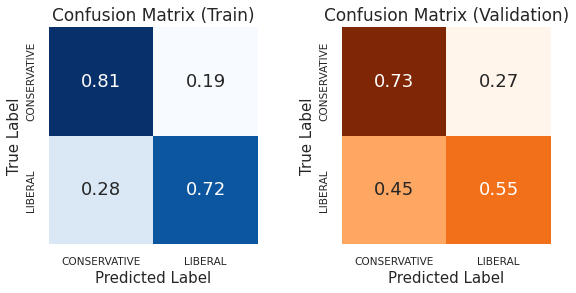

In [305]:
plot_validation_confusion_matrices(y_train_stance_true, 
                            y_train_stance_pred, 
                            y_validate_stance_true, 
                            y_validate_stance_pred, 
                            target_names=lb_stance.classes_, 
                            normalize="true", 
                            sample_weight=stance_weights,
                            figsize=(9,4),
                            filepath=f"images/{''.join(MODEL_NAME.split('_'))}/STANCE-validation-confusion-matrices.png")

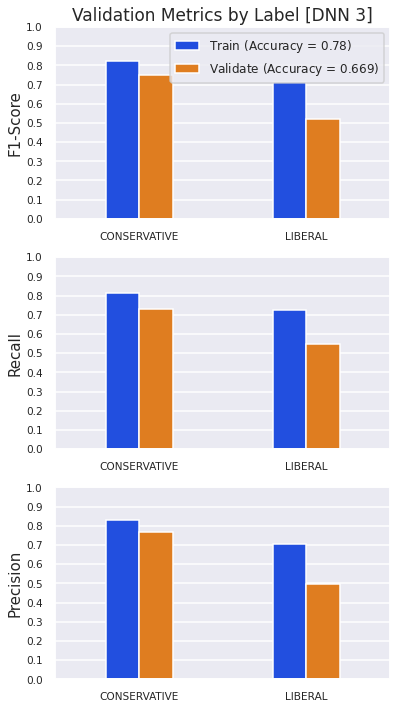

In [306]:
plot_multilabel_validation_metrics(y_train_stance_true, 
                                   y_train_stance_pred, 
                                   y_validate_stance_true, 
                                   y_validate_stance_pred, 
                                   score_names = ['f1-score', 'recall', 'precision'],
                                   score_labels=["F1-Score", "Recall", "Precision"],
                                   target_names=lb_stance.classes_,
                                   estimator_label=f"{' '.join(MODEL_NAME.split('_')).upper()}",                                  
                                   sample_weight=stance_weights,
                                   mode="validate",
                                   filepath=f"images/{''.join(MODEL_NAME.split('_'))}/STANCE-validation-metrics.png")

In [307]:
dnn3_val_metrics_stance = get_classification_metrics(y_validate_stance_true, 
                                                            y_validate_stance_pred, 
                                                            target_names=lb_stance.classes_)

dnn3_average_f1_score_stance = dnn3_val_metrics_stance.loc["F1-Score"]["Average"]
dnn3_average_f1_score_stance

0.633

#### *`DNN 4`*

In [308]:
MODEL_NAME = "dnn_4"

loaded_model = load_model(f"models/{''.join(MODEL_NAME.split('_'))}.h5")

y_train_pred = loaded_model.predict(X_train_TV)
y_validate_pred = loaded_model.predict(X_validate_TV)

y_train_issue_pred = lb_issue.inverse_transform(y_train_pred[0])
y_validate_issue_pred = lb_issue.inverse_transform(y_validate_pred[0])

y_train_stance_pred = lb_stance.inverse_transform(y_train_pred[1])
y_validate_stance_pred = lb_stance.inverse_transform(y_validate_pred[1])

291/291 [==============================] - 2s 8ms/step


##### `ISSUE`

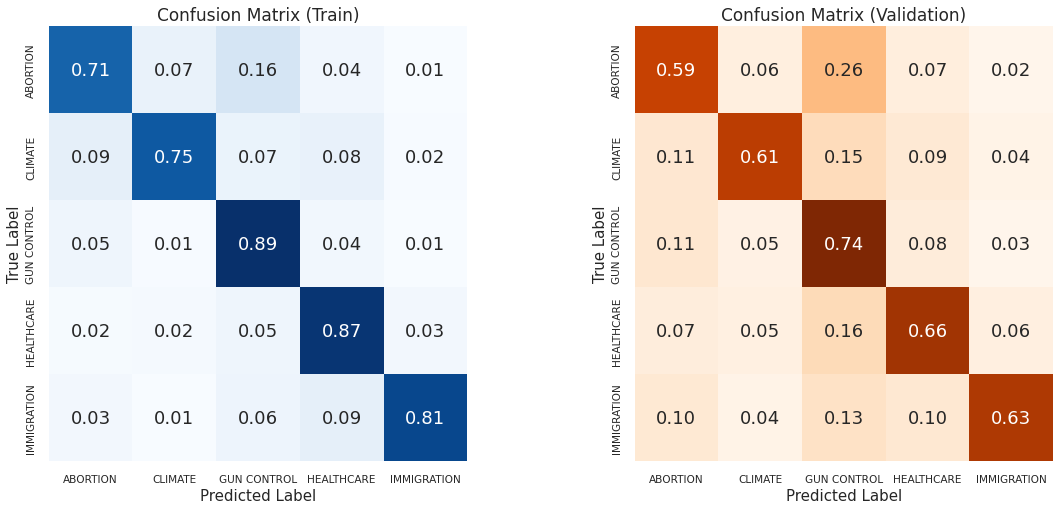

In [309]:
plot_validation_confusion_matrices(y_train_issue_true, 
                                        y_train_issue_pred, 
                                        y_validate_issue_true, 
                                        y_validate_issue_pred, 
                                        target_names=lb_issue.classes_, 
                                        normalize="true", 
                                        sample_weight=issue_weights,
                                        figsize=(18,8),
                                        filepath=f"images/{''.join(MODEL_NAME.split('_'))}/ISSUE-validation-confusion-matrices.png")

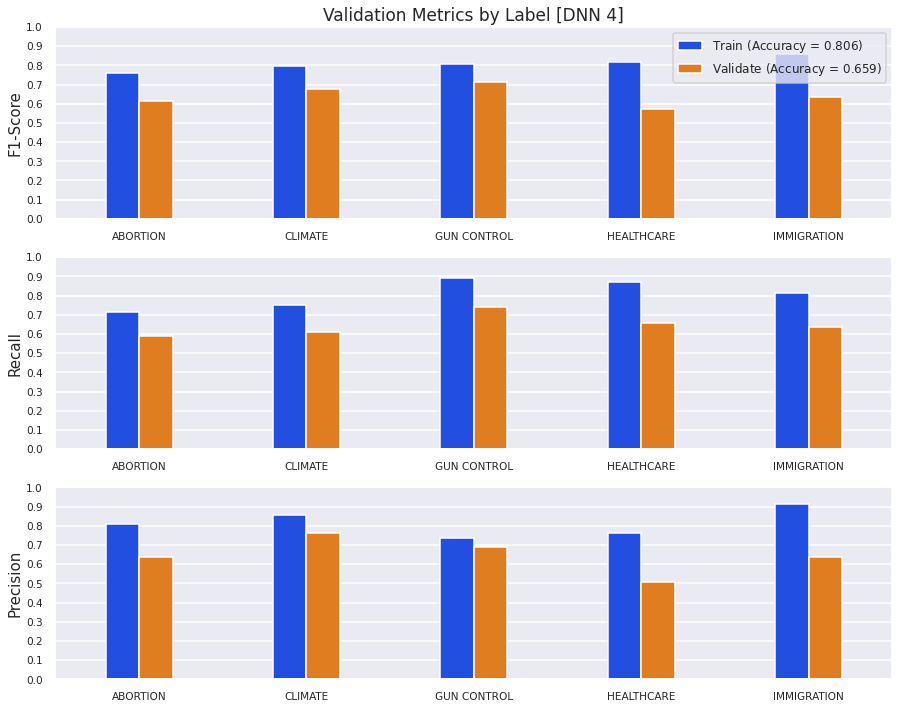

In [310]:
plot_multilabel_validation_metrics(y_train_issue_true, 
                                        y_train_issue_pred, 
                                        y_validate_issue_true, 
                                        y_validate_issue_pred, 
                                        score_names = ['f1-score', 'recall', 'precision'],
                                        score_labels=["F1-Score", "Recall", "Precision"],
                                        target_names=lb_issue.classes_,
                                        estimator_label=f"{' '.join(MODEL_NAME.split('_')).upper()}",
                                        sample_weight=issue_weights,
                                        mode="validate",
                                        filepath=f"images/{''.join(MODEL_NAME.split('_'))}/ISSUE-validation-metrics.png")

In [311]:
dnn4_val_metrics_issue = get_classification_metrics(y_validate_issue_true, 
                                                            y_validate_issue_pred, 
                                                            target_names=lb_issue.classes_)

dnn4_average_f1_score_issue = dnn4_val_metrics_issue.loc["F1-Score"]["Average"]
dnn4_average_f1_score_issue

0.643

##### `STANCE`

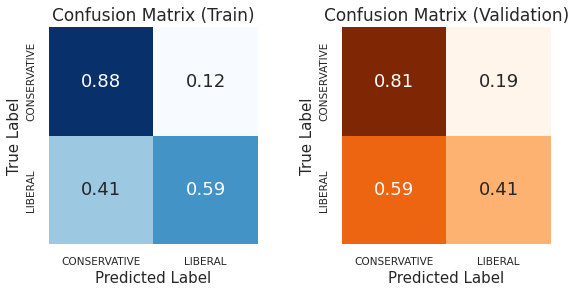

In [312]:
plot_validation_confusion_matrices(y_train_stance_true, 
                            y_train_stance_pred, 
                            y_validate_stance_true, 
                            y_validate_stance_pred, 
                            target_names=lb_stance.classes_, 
                            normalize="true", 
                            sample_weight=stance_weights,
                            figsize=(9,4),
                            filepath=f"images/{''.join(MODEL_NAME.split('_'))}/STANCE-validation-confusion-matrices.png")

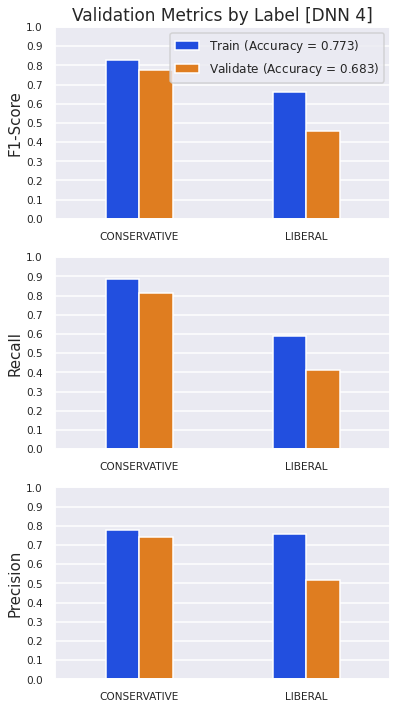

In [313]:
plot_multilabel_validation_metrics(y_train_stance_true, 
                                   y_train_stance_pred, 
                                   y_validate_stance_true, 
                                   y_validate_stance_pred, 
                                   score_names = ['f1-score', 'recall', 'precision'],
                                   score_labels=["F1-Score", "Recall", "Precision"],
                                   target_names=lb_stance.classes_,
                                   estimator_label=f"{' '.join(MODEL_NAME.split('_')).upper()}",                                 
                                   sample_weight=stance_weights,
                                   mode="validate",
                                   filepath=f"images/{''.join(MODEL_NAME.split('_'))}/STANCE-validation-metrics.png")

In [314]:
dnn4_val_metrics_stance = get_classification_metrics(y_validate_stance_true, 
                                                            y_validate_stance_pred, 
                                                            target_names=lb_stance.classes_)

dnn4_average_f1_score_stance = dnn4_val_metrics_stance.loc["F1-Score"]["Average"]
dnn4_average_f1_score_stance

0.618

#### *`DNN 5`*

In [216]:
MODEL_NAME = "dnn_5"

loaded_model = load_model(f"models/{''.join(MODEL_NAME.split('_'))}.h5")

y_train_pred = loaded_model.predict(X_train_TV)
y_validate_pred = loaded_model.predict(X_validate_TV)

y_train_issue_pred = lb_issue.inverse_transform(y_train_pred[0])
y_validate_issue_pred = lb_issue.inverse_transform(y_validate_pred[0])

y_train_stance_pred = lb_stance.inverse_transform(y_train_pred[1])
y_validate_stance_pred = lb_stance.inverse_transform(y_validate_pred[1])

291/291 [==============================] - 2s 6ms/step


##### `ISSUE`

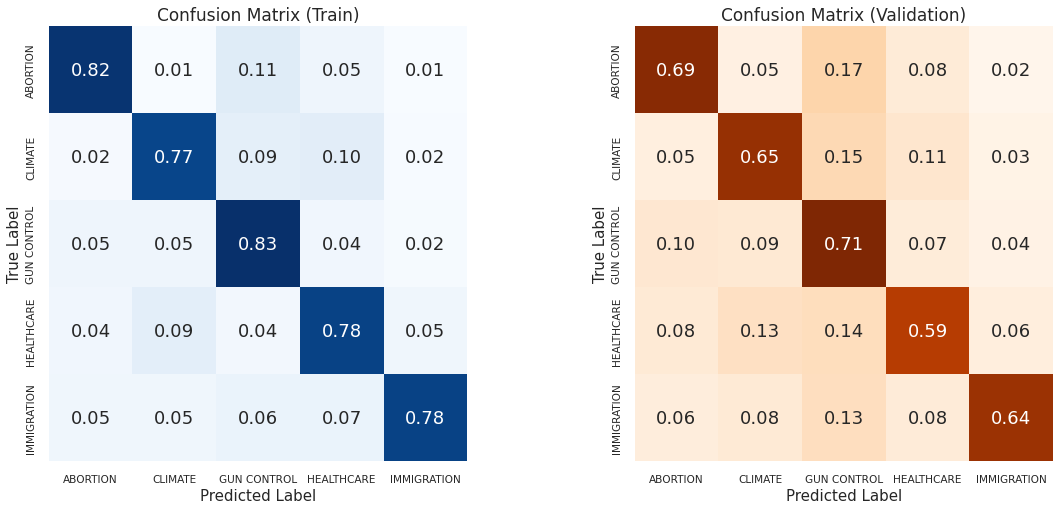

In [217]:
plot_validation_confusion_matrices(y_train_issue_true, 
                                        y_train_issue_pred, 
                                        y_validate_issue_true, 
                                        y_validate_issue_pred, 
                                        target_names=lb_issue.classes_, 
                                        normalize="true", 
                                        sample_weight=issue_weights,
                                        figsize=(18,8),
                                        filepath=f"images/{''.join(MODEL_NAME.split('_'))}/ISSUE-validation-confusion-matrices.png")

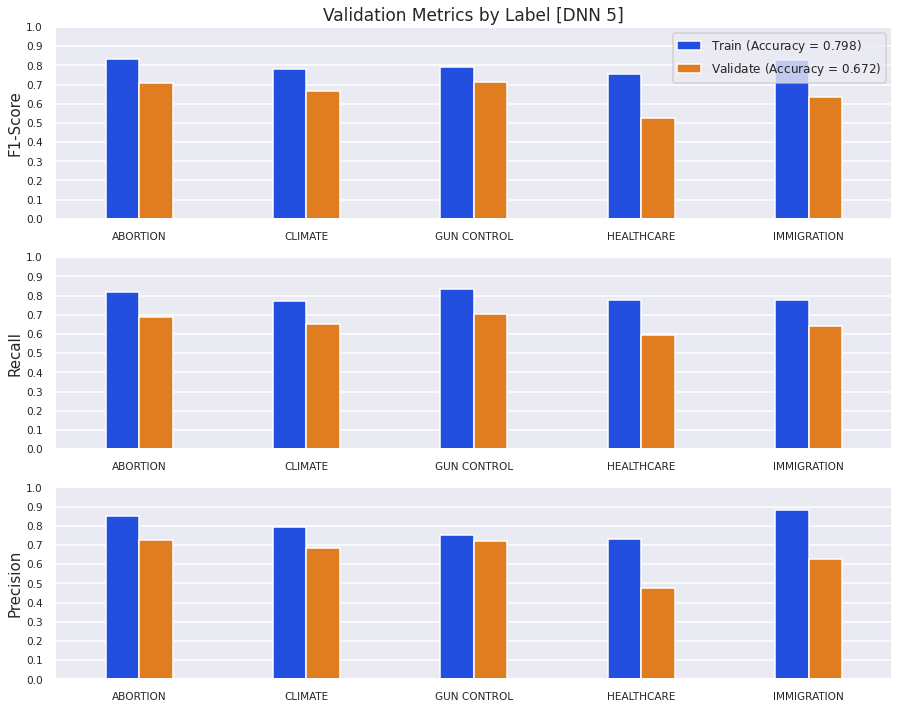

In [218]:
plot_multilabel_validation_metrics(y_train_issue_true, 
                                        y_train_issue_pred, 
                                        y_validate_issue_true, 
                                        y_validate_issue_pred, 
                                        score_names = ['f1-score', 'recall', 'precision'],
                                        score_labels=["F1-Score", "Recall", "Precision"],
                                        target_names=lb_issue.classes_,
                                        estimator_label=f"{' '.join(MODEL_NAME.split('_')).upper()}",
                                        sample_weight=issue_weights,
                                        mode="validate",
                                        filepath=f"images/{''.join(MODEL_NAME.split('_'))}/ISSUE-validation-metrics.png")

In [219]:
dnn5_val_metrics_issue = get_classification_metrics(y_validate_issue_true, 
                                                            y_validate_issue_pred, 
                                                            target_names=lb_issue.classes_)

dnn5_average_f1_score_issue = dnn5_val_metrics_issue.loc["F1-Score"]["Average"]
dnn5_average_f1_score_issue

0.65

##### `STANCE`

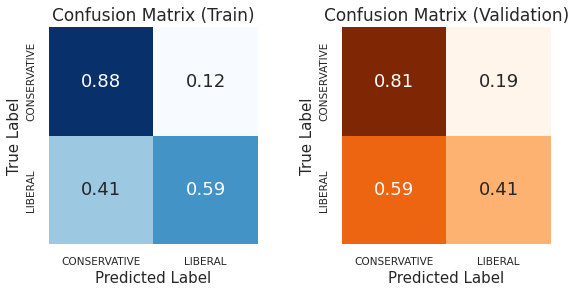

In [315]:
plot_validation_confusion_matrices(y_train_stance_true, 
                            y_train_stance_pred, 
                            y_validate_stance_true, 
                            y_validate_stance_pred, 
                            target_names=lb_stance.classes_, 
                            normalize="true", 
                            sample_weight=stance_weights,
                            figsize=(9,4),
                            filepath=f"images/{''.join(MODEL_NAME.split('_'))}/STANCE-validation-confusion-matrices.png")

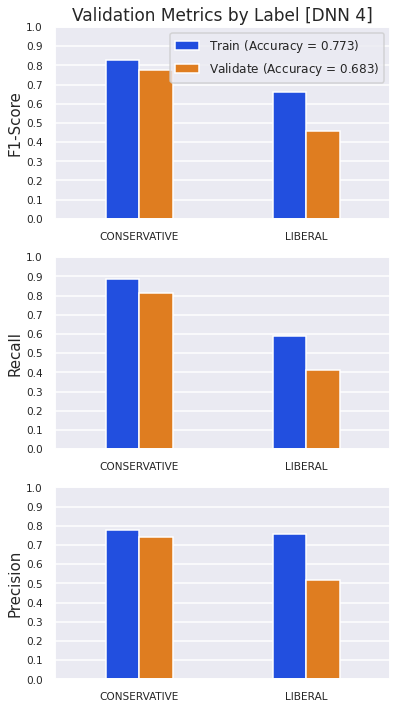

In [316]:
plot_multilabel_validation_metrics(y_train_stance_true, 
                                   y_train_stance_pred, 
                                   y_validate_stance_true, 
                                   y_validate_stance_pred, 
                                   score_names = ['f1-score', 'recall', 'precision'],
                                   score_labels=["F1-Score", "Recall", "Precision"],
                                   target_names=lb_stance.classes_,
                                   estimator_label=f"{' '.join(MODEL_NAME.split('_')).upper()}",
                                   
                                   sample_weight=stance_weights,
                                   mode="validate",
                                   filepath=f"images/{''.join(MODEL_NAME.split('_'))}/STANCE-validation-metrics.png")

In [317]:
dnn5_val_metrics_stance = get_classification_metrics(y_validate_stance_true, 
                                                            y_validate_stance_pred, 
                                                            target_names=lb_stance.classes_)

dnn5_average_f1_score_stance = dnn5_val_metrics_stance.loc["F1-Score"]["Average"]
dnn5_average_f1_score_stance

0.618

## D.3 - Transformer Encoder Network (TEN)

> A series of Transformer Encoder Networks were trained on the Training Set. The inputs to these models were the integer-encoded vectors produced by the `TextVectorization` layer in ***Section C.5.1*** (`X_train_IE`, `X_validate_IE`, and `X_test_IE`). The main parameters being altered were: the architecture (number of heads in the `MultiheadAttention` layer) and the droput rate within the `TransformerEncoder` layer.

### *D.3.1 - Defining the Network Layers*

> The Transformer Encoder Network utilized two custom layers subclassed by the `keras.layers.Layer` base layer class. These were a `TransformerEncoder` containing a `MultiHeadAttention` layer, and `PositionalTokenEmbedding` layer, which took into account token positions in the sequence as they were fed into the model.

In [228]:
class TransformerEncoder(Layer):
    def __init__(self, embedding_dim, num_heads, dense_dim, dropout_rate=0.1, **kwargs):
        super(TransformerEncoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.dense_dim = dense_dim
        
        self.attention_layer = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
        self.dense_layers = Sequential([Dense(dense_dim, activation="relu"), 
                                            Dense(embedding_dim),])
        
        self.normalization_layer_1 = LayerNormalization(epsilon=1e-6)
        self.normalization_layer_2 = LayerNormalization(epsilon=1e-6)
        
        self.dropout_layer_1 = Dropout(dropout_rate)
        self.dropout_layer_2 = Dropout(dropout_rate)

    def call(self, inputs, training):
        attention_output = self.attention_layer(inputs, inputs)
        attention_output = self.dropout_layer_1(attention_output, training=training)
        
        dense_input = self.normalization_layer_1(inputs + attention_output)
        
        dense_output = self.dense_layers(dense_input)
        dense_output = self.dropout_layer_2(dense_output, training=training)
        
        return self.normalization_layer_2(dense_input +dense_output)
    
    def get_config(self):
        config = super().get_config() 
        config.update({"embedding_dim": self.embedding_dim, 
                        "num_heads": self.num_heads, 
                        "dense_dim": self.dense_dim}) 
        return config

class PositionalTokenEmbedding(Layer):
    def __init__(self, max_sequence_length, vocabulary_size, embedding_dim, **kwargs):
        super(PositionalTokenEmbedding, self).__init__()
        self.max_sequence_length = max_sequence_length
        self.input_dim = vocabulary_size
        self.output_dim = embedding_dim
        self.token_embeddings = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim)
        self.position_embeddings = Embedding(input_dim=max_sequence_length, output_dim=embedding_dim)

    def call(self, inputs):
        max_sequence_length = tf.shape(inputs)[-1]
        input_positions = tf.range(start=0, limit=max_sequence_length, delta=1)
        embedded_positions = self.position_embeddings(input_positions)
        embedded_tokens = self.token_embeddings(inputs)
        return embedded_tokens + embedded_positions
    
    def get_config(self):
        config = super().get_config() 
        config.update({"max_sequence_length": self.max_sequence_length,
                        "vocabulary_size": self.input_dim,
                        "embedding_dim": self.output_dim})
        return config

### *D.2.2 - Building and Training Various Architectures*

Epoch 1/100
339/339 [==============================] - 43s 120ms/step - loss: 2.6258 - issue_loss: 1.5934 - stance_loss: 1.0324 - issue_accuracy: 0.4282 - stance_accuracy: 0.6425 - val_loss: 1.4994 - val_issue_loss: 0.8805 - val_stance_loss: 0.6190 - val_issue_accuracy: 0.6848 - val_stance_accuracy: 0.6575
Epoch 2/100
339/339 [==============================] - 41s 121ms/step - loss: 1.7725 - issue_loss: 0.9216 - stance_loss: 0.8509 - issue_accuracy: 0.7106 - stance_accuracy: 0.7130 - val_loss: 1.3940 - val_issue_loss: 0.8223 - val_stance_loss: 0.5718 - val_issue_accuracy: 0.6866 - val_stance_accuracy: 0.7040
Epoch 3/100
339/339 [==============================] - 41s 122ms/step - loss: 1.4456 - issue_loss: 0.7304 - stance_loss: 0.7151 - issue_accuracy: 0.7632 - stance_accuracy: 0.7562 - val_loss: 1.4579 - val_issue_loss: 0.8605 - val_stance_loss: 0.5974 - val_issue_accuracy: 0.6872 - val_stance_accuracy: 0.6901
Epoch 4/100
339/339 [==============================] - 40s 119ms/step - loss

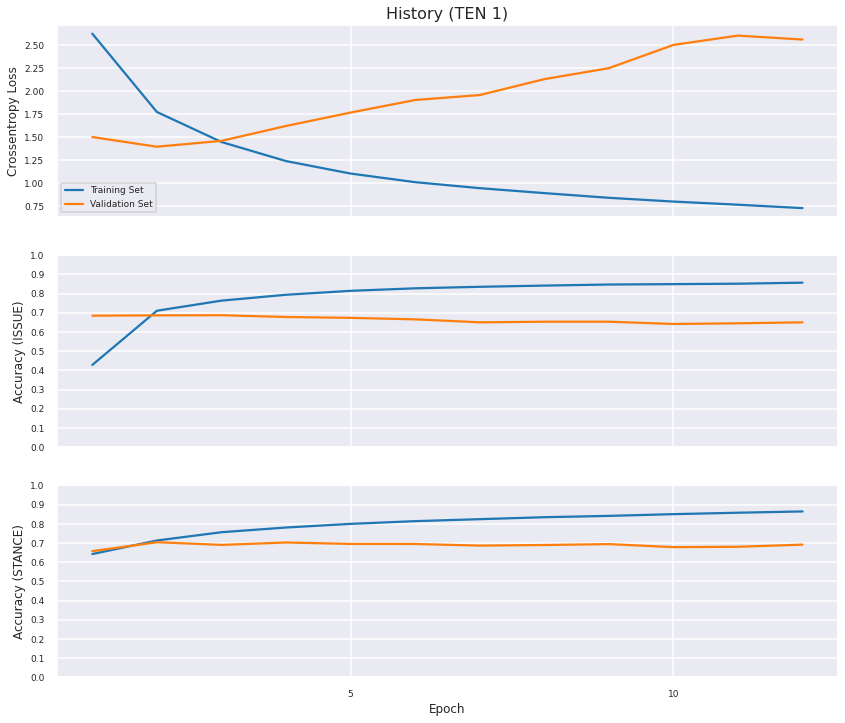

In [229]:
EMBEDDING_DIM = 128 
NUM_HEADS = 1 
DENSE_DIM = 64


MODEL_NAME = "ten_1"

comment = Input(shape=(MAX_DOCUMENT_LENGTH,), name="comment")  
x = PositionalTokenEmbedding(max_sequence_length=MAX_DOCUMENT_LENGTH, vocabulary_size=VOCABULARY_SIZE, embedding_dim=EMBEDDING_DIM)(comment) 
x = TransformerEncoder(embedding_dim=EMBEDDING_DIM, dense_dim=DENSE_DIM, num_heads=NUM_HEADS)(x) 
x = GlobalAveragePooling1D()(x) 
x = Dropout(0.2)(x) 
stance = Dense(1, activation="sigmoid", name="stance")(x)
issue = Dense(NUM_ISSUES, activation="softmax", name="issue")(x)

ten = Model(inputs=comment, outputs=[issue, stance], name=MODEL_NAME)

ten.compile(optimizer="Adam", 
                loss={"issue": "categorical_crossentropy", "stance": "binary_crossentropy"},
                metrics="accuracy")

checkpoint = ModelCheckpoint(filepath=f"models/{''.join(MODEL_NAME.split('_'))}.h5",
                                save_best_only=True,
                                monitor="val_loss",
                                mode="min")
with tf.device("GPU"):
    history = ten.fit(X_train_IE, 
                       {"issue": y_train_issue, "stance": y_train_stance}, 
                       batch_size=128,
                       epochs=100,        
                       validation_data=(X_validate_IE, {"issue": y_validate_issue, "stance": y_validate_stance}),
                       validation_batch_size=32,
                       sample_weight={"issue": issue_weights, "stance": stance_weights}, 
                       callbacks=[early_stopping, checkpoint],
                       verbose=1)

plot_history(MODEL_NAME, 
              history.history, 
              filepath=f"images/{''.join(MODEL_NAME.split('_'))}/history.png",
              figsize=(14,12))

Epoch 1/100
339/339 [==============================] - 58s 167ms/step - loss: 2.6284 - issue_loss: 1.5959 - stance_loss: 1.0326 - issue_accuracy: 0.4284 - stance_accuracy: 0.6404 - val_loss: 1.5225 - val_issue_loss: 0.8854 - val_stance_loss: 0.6371 - val_issue_accuracy: 0.6669 - val_stance_accuracy: 0.6008
Epoch 2/100
339/339 [==============================] - 56s 164ms/step - loss: 1.7677 - issue_loss: 0.9184 - stance_loss: 0.8494 - issue_accuracy: 0.7120 - stance_accuracy: 0.7115 - val_loss: 1.4321 - val_issue_loss: 0.8632 - val_stance_loss: 0.5689 - val_issue_accuracy: 0.6740 - val_stance_accuracy: 0.7103
Epoch 3/100
339/339 [==============================] - 56s 165ms/step - loss: 1.4408 - issue_loss: 0.7279 - stance_loss: 0.7130 - issue_accuracy: 0.7621 - stance_accuracy: 0.7587 - val_loss: 1.4747 - val_issue_loss: 0.8689 - val_stance_loss: 0.6058 - val_issue_accuracy: 0.6750 - val_stance_accuracy: 0.7049
Epoch 4/100
339/339 [==============================] - 54s 160ms/step - loss

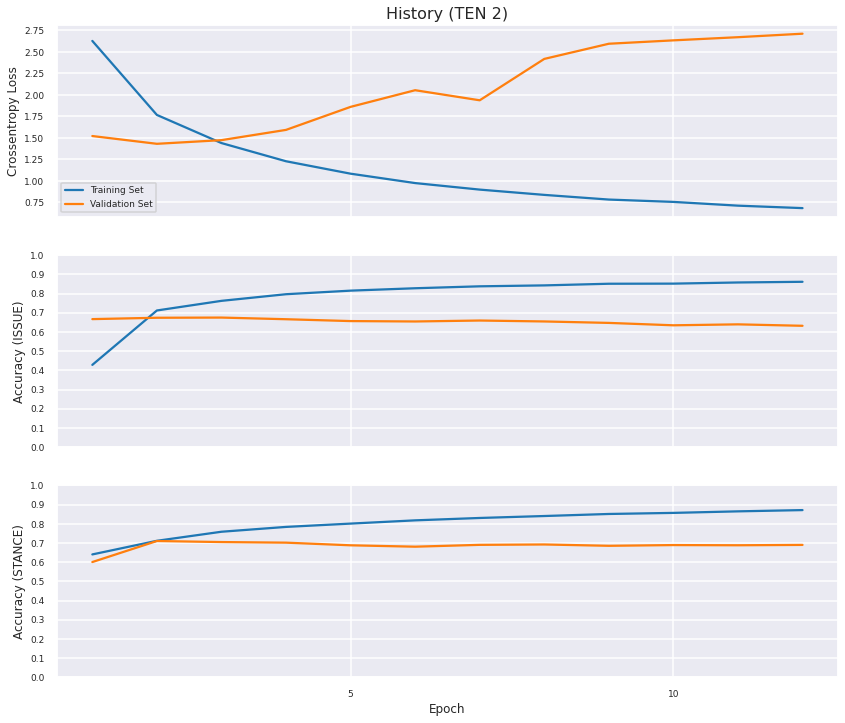

In [236]:
EMBEDDING_DIM = 128 
NUM_HEADS = 2 
DENSE_DIM = 64


MODEL_NAME = "ten_2"

comment = Input(shape=(MAX_DOCUMENT_LENGTH,), name="comment")  
x = PositionalTokenEmbedding(max_sequence_length=MAX_DOCUMENT_LENGTH, vocabulary_size=VOCABULARY_SIZE, embedding_dim=EMBEDDING_DIM)(comment) 
x = TransformerEncoder(embedding_dim=EMBEDDING_DIM, dense_dim=DENSE_DIM, num_heads=NUM_HEADS)(x) 
x = GlobalAveragePooling1D()(x) 
x = Dropout(0.2)(x) 
stance = Dense(1, activation="sigmoid", name="stance")(x)
issue = Dense(NUM_ISSUES, activation="softmax", name="issue")(x)

ten = Model(inputs=comment, outputs=[issue, stance], name=MODEL_NAME)

ten.compile(optimizer="Adam", 
                loss={"issue": "categorical_crossentropy", "stance": "binary_crossentropy"},
                metrics="accuracy")

checkpoint = ModelCheckpoint(filepath=f"models/{''.join(MODEL_NAME.split('_'))}.h5",
                                save_best_only=True,
                                monitor="val_loss",
                                mode="min")
with tf.device("GPU"):
    history = ten.fit(X_train_IE, 
                       {"issue": y_train_issue, "stance": y_train_stance}, 
                       batch_size=128,
                       epochs=100,        
                       validation_data=(X_validate_IE, {"issue": y_validate_issue, "stance": y_validate_stance}),
                       validation_batch_size=32,
                       sample_weight={"issue": issue_weights, "stance": stance_weights}, 
                       callbacks=[early_stopping, checkpoint],
                       verbose=1)

plot_history(MODEL_NAME, 
              history.history, 
              filepath=f"images/{''.join(MODEL_NAME.split('_'))}/history.png",
              figsize=(14,12))

Epoch 1/100
339/339 [==============================] - 75s 214ms/step - loss: 2.7330 - issue_loss: 1.6923 - stance_loss: 1.0407 - issue_accuracy: 0.3855 - stance_accuracy: 0.6450 - val_loss: 1.5003 - val_issue_loss: 0.8647 - val_stance_loss: 0.6355 - val_issue_accuracy: 0.6772 - val_stance_accuracy: 0.6631
Epoch 2/100
339/339 [==============================] - 73s 216ms/step - loss: 1.7915 - issue_loss: 0.9371 - stance_loss: 0.8544 - issue_accuracy: 0.7068 - stance_accuracy: 0.7087 - val_loss: 1.4907 - val_issue_loss: 0.9132 - val_stance_loss: 0.5775 - val_issue_accuracy: 0.6560 - val_stance_accuracy: 0.7074
Epoch 3/100
339/339 [==============================] - 73s 214ms/step - loss: 1.4516 - issue_loss: 0.7403 - stance_loss: 0.7114 - issue_accuracy: 0.7594 - stance_accuracy: 0.7555 - val_loss: 1.5550 - val_issue_loss: 0.9149 - val_stance_loss: 0.6401 - val_issue_accuracy: 0.6728 - val_stance_accuracy: 0.6848
Epoch 4/100
339/339 [==============================] - 73s 215ms/step - loss

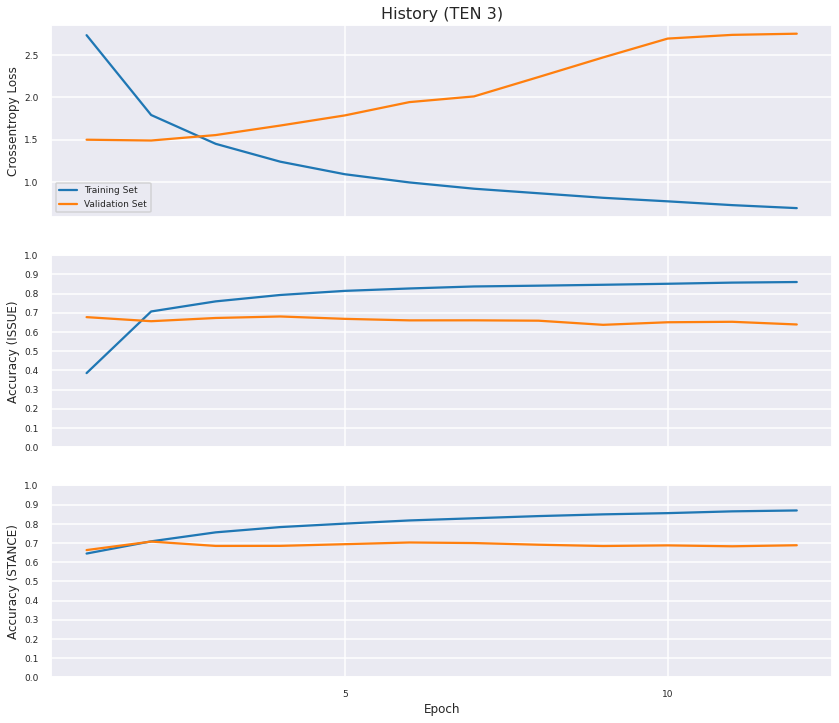

In [238]:
EMBEDDING_DIM = 128 
NUM_HEADS = 3 
DENSE_DIM = 64


MODEL_NAME = "ten_3"

comment = Input(shape=(MAX_DOCUMENT_LENGTH,), name="comment")  
x = PositionalTokenEmbedding(max_sequence_length=MAX_DOCUMENT_LENGTH, vocabulary_size=VOCABULARY_SIZE, embedding_dim=EMBEDDING_DIM)(comment) 
x = TransformerEncoder(embedding_dim=EMBEDDING_DIM, dense_dim=DENSE_DIM, num_heads=NUM_HEADS, dropout_rate=0.2)(x) 
x = GlobalAveragePooling1D()(x) 
x = Dropout(0.2)(x) 
stance = Dense(1, activation="sigmoid", name="stance")(x)
issue = Dense(NUM_ISSUES, activation="softmax", name="issue")(x)

ten = Model(inputs=comment, outputs=[issue, stance], name=MODEL_NAME)

ten.compile(optimizer="Adam", 
                loss={"issue": "categorical_crossentropy", "stance": "binary_crossentropy"},
                metrics="accuracy")

checkpoint = ModelCheckpoint(filepath=f"models/{''.join(MODEL_NAME.split('_'))}.h5",
                                save_best_only=True,
                                monitor="val_loss",
                                mode="min")
with tf.device("GPU"):
    history = ten.fit(X_train_IE, 
                       {"issue": y_train_issue, "stance": y_train_stance}, 
                       batch_size=128,
                       epochs=100,        
                       validation_data=(X_validate_IE, {"issue": y_validate_issue, "stance": y_validate_stance}),
                       validation_batch_size=32,
                       sample_weight={"issue": issue_weights, "stance": stance_weights}, 
                       callbacks=[early_stopping, checkpoint],
                       verbose=1)

plot_history(MODEL_NAME, 
              history.history, 
              filepath=f"images/{''.join(MODEL_NAME.split('_'))}/history.png",
              figsize=(14,12))

Epoch 1/100
339/339 [==============================] - 74s 213ms/step - loss: 2.7773 - issue_loss: 1.7262 - stance_loss: 1.0511 - issue_accuracy: 0.3704 - stance_accuracy: 0.6386 - val_loss: 1.5076 - val_issue_loss: 0.9043 - val_stance_loss: 0.6033 - val_issue_accuracy: 0.6805 - val_stance_accuracy: 0.6814
Epoch 2/100
339/339 [==============================] - 72s 211ms/step - loss: 1.8250 - issue_loss: 0.9618 - stance_loss: 0.8632 - issue_accuracy: 0.7018 - stance_accuracy: 0.7049 - val_loss: 1.4034 - val_issue_loss: 0.8232 - val_stance_loss: 0.5802 - val_issue_accuracy: 0.6920 - val_stance_accuracy: 0.7026
Epoch 3/100
339/339 [==============================] - 72s 212ms/step - loss: 1.4726 - issue_loss: 0.7510 - stance_loss: 0.7216 - issue_accuracy: 0.7597 - stance_accuracy: 0.7547 - val_loss: 1.5035 - val_issue_loss: 0.8837 - val_stance_loss: 0.6198 - val_issue_accuracy: 0.6956 - val_stance_accuracy: 0.7043
Epoch 4/100
339/339 [==============================] - 72s 211ms/step - loss

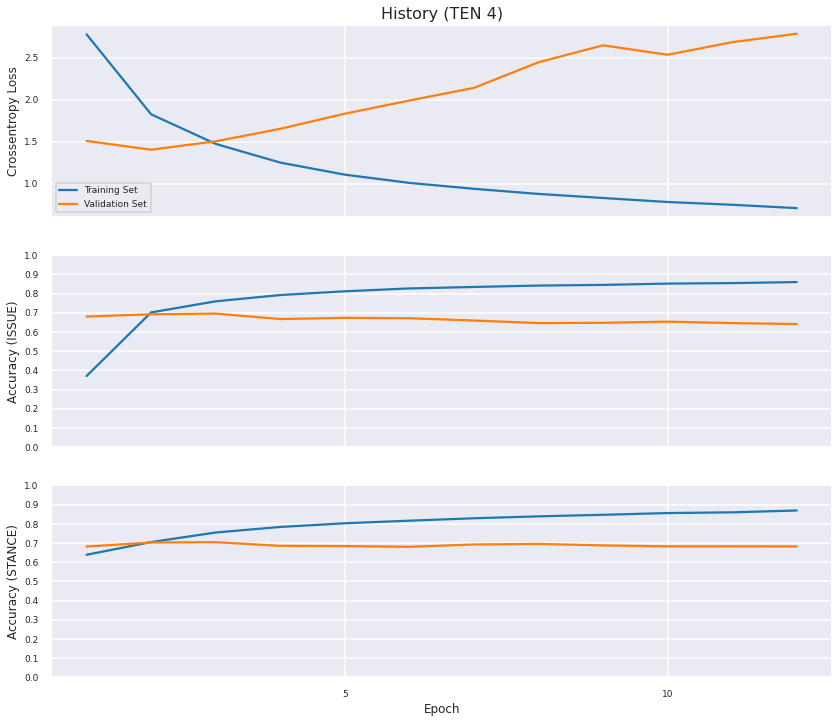

In [237]:
EMBEDDING_DIM = 128 
NUM_HEADS = 3 
DENSE_DIM = 64


MODEL_NAME = "ten_4"

comment = Input(shape=(MAX_DOCUMENT_LENGTH,), name="comment")  
x = PositionalTokenEmbedding(max_sequence_length=MAX_DOCUMENT_LENGTH, vocabulary_size=VOCABULARY_SIZE, embedding_dim=EMBEDDING_DIM)(comment) 
x = TransformerEncoder(embedding_dim=EMBEDDING_DIM, dense_dim=DENSE_DIM, num_heads=NUM_HEADS, dropout_rate=0.3)(x) 
x = GlobalAveragePooling1D()(x) 
x = Dropout(0.3)(x) 
stance = Dense(1, activation="sigmoid", name="stance")(x)
issue = Dense(NUM_ISSUES, activation="softmax", name="issue")(x)

ten = Model(inputs=comment, outputs=[issue, stance], name=MODEL_NAME)

ten.compile(optimizer="Adam", 
                loss={"issue": "categorical_crossentropy", "stance": "binary_crossentropy"},
                metrics="accuracy")

checkpoint = ModelCheckpoint(filepath=f"models/{''.join(MODEL_NAME.split('_'))}.h5",
                                save_best_only=True,
                                monitor="val_loss",
                                mode="min")
with tf.device("GPU"):
    history = ten.fit(X_train_IE, 
                       {"issue": y_train_issue, "stance": y_train_stance}, 
                       batch_size=128,
                       epochs=100,        
                       validation_data=(X_validate_IE, {"issue": y_validate_issue, "stance": y_validate_stance}),
                       validation_batch_size=32,
                       sample_weight={"issue": issue_weights, "stance": stance_weights}, 
                       callbacks=[early_stopping, checkpoint],
                       verbose=1)

plot_history(MODEL_NAME, 
              history.history, 
              filepath=f"images/{''.join(MODEL_NAME.split('_'))}/history.png",
              figsize=(14,12))

### *D.3.2 - Model Validation*

#### *`TEN 1`*

In [239]:
MODEL_NAME = "ten_1"

loaded_model = load_model(f"models/{''.join(MODEL_NAME.split('_'))}.h5", custom_objects={"TransformerEncoder": TransformerEncoder, "PositionalTokenEmbedding": PositionalTokenEmbedding})

y_train_pred = loaded_model.predict(X_train_IE)
y_validate_pred = loaded_model.predict(X_validate_IE)

y_train_issue_pred = lb_issue.inverse_transform(y_train_pred[0])
y_validate_issue_pred = lb_issue.inverse_transform(y_validate_pred[0])

y_train_stance_pred = lb_stance.inverse_transform(y_train_pred[1])
y_validate_stance_pred = lb_stance.inverse_transform(y_validate_pred[1])

291/291 [==============================] - 4s 14ms/step


##### `ISSUE`

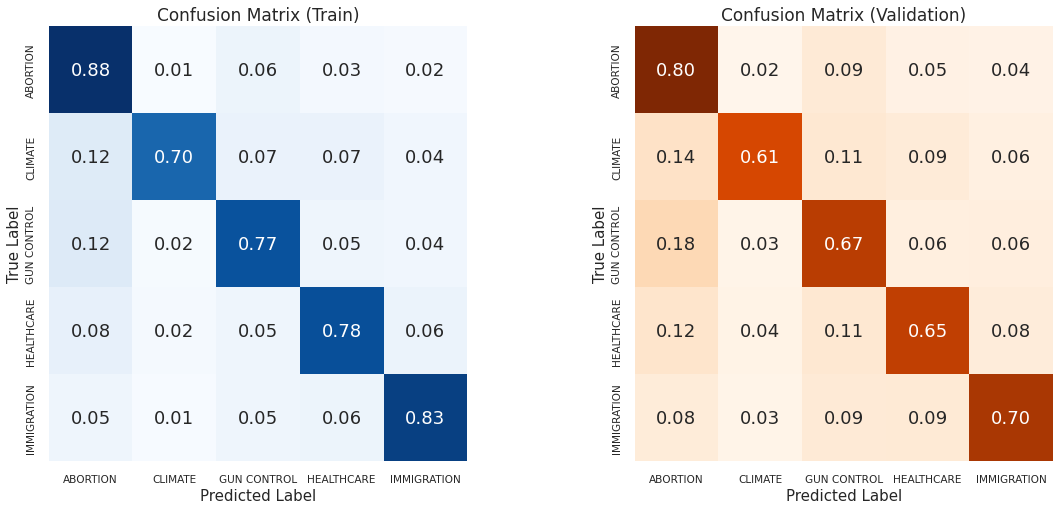

In [240]:
plot_validation_confusion_matrices(y_train_issue_true, 
                                        y_train_issue_pred, 
                                        y_validate_issue_true, 
                                        y_validate_issue_pred, 
                                        target_names=lb_issue.classes_, 
                                        normalize="true", 
                                        sample_weight=issue_weights,
                                        figsize=(18,8),
                                        filepath=f"images/{''.join(MODEL_NAME.split('_'))}/ISSUE-validation-confusion-matrices.png")

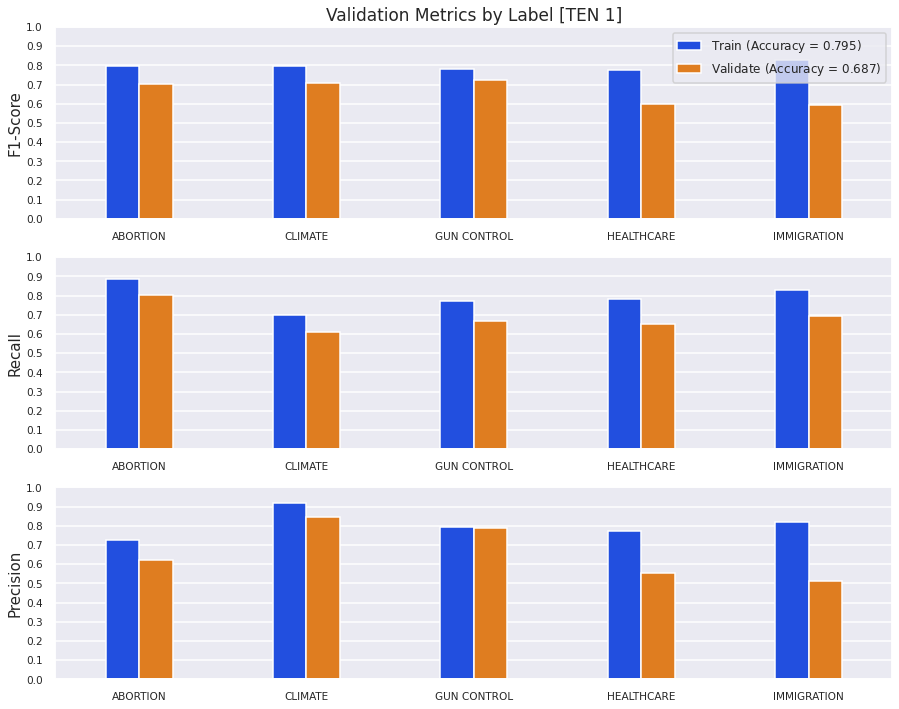

In [241]:
plot_multilabel_validation_metrics(y_train_issue_true, 
                                        y_train_issue_pred, 
                                        y_validate_issue_true, 
                                        y_validate_issue_pred, 
                                        score_names = ['f1-score', 'recall', 'precision'],
                                        score_labels=["F1-Score", "Recall", "Precision"],
                                        target_names=lb_issue.classes_,
                                        estimator_label=f"{' '.join(MODEL_NAME.split('_')).upper()}",
                                        sample_weight=issue_weights,
                                        mode="validate",
                                        filepath=f"images/{''.join(MODEL_NAME.split('_'))}/ISSUE-validation-metrics.png")

In [242]:
ten1_val_metrics_issue = get_classification_metrics(y_validate_issue_true, 
                                                            y_validate_issue_pred, 
                                                            target_names=lb_issue.classes_)

ten1_average_f1_score_issue = ten1_val_metrics_issue.loc["F1-Score"]["Average"]
ten1_average_f1_score_issue

0.665

##### `STANCE`

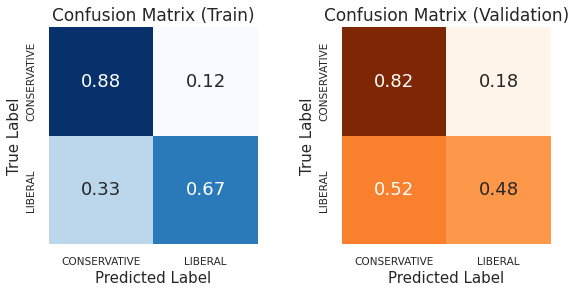

In [243]:
plot_validation_confusion_matrices(y_train_stance_true, 
                            y_train_stance_pred, 
                            y_validate_stance_true, 
                            y_validate_stance_pred, 
                            target_names=lb_stance.classes_, 
                            normalize="true", 
                            sample_weight=stance_weights,
                            figsize=(9,4),
                            filepath=f"images/{''.join(MODEL_NAME.split('_'))}/STANCE-validation-confusion-matrices.png")

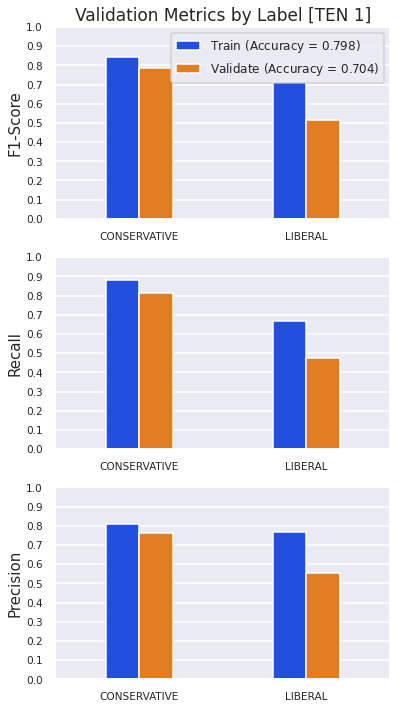

In [244]:
plot_multilabel_validation_metrics(y_train_stance_true, 
                                   y_train_stance_pred, 
                                   y_validate_stance_true, 
                                   y_validate_stance_pred, 
                                   score_names = ['f1-score', 'recall', 'precision'],
                                   score_labels=["F1-Score", "Recall", "Precision"],
                                   target_names=lb_stance.classes_,
                                   estimator_label=f"{' '.join(MODEL_NAME.split('_')).upper()}",
                                   sample_weight=stance_weights,
                                   mode="validate",
                                   filepath=f"images/{''.join(MODEL_NAME.split('_'))}/STANCE-validation-metrics.png")

In [246]:
ten1_val_metrics_stance = get_classification_metrics(y_validate_stance_true, 
                                                            y_validate_stance_pred, 
                                                            target_names=lb_stance.classes_)

ten1_average_f1_score_stance = ten1_val_metrics_stance.loc["F1-Score"]["Average"]
ten1_average_f1_score_stance

0.65

#### *`TEN 2`*

In [272]:
MODEL_NAME = "ten_2"

loaded_model = load_model(f"models/{''.join(MODEL_NAME.split('_'))}.h5", custom_objects={"TransformerEncoder": TransformerEncoder, "PositionalTokenEmbedding": PositionalTokenEmbedding})

y_train_pred = loaded_model.predict(X_train_IE)
y_validate_pred = loaded_model.predict(X_validate_IE)

y_train_issue_pred = lb_issue.inverse_transform(y_train_pred[0])
y_validate_issue_pred = lb_issue.inverse_transform(y_validate_pred[0])

y_train_stance_pred = lb_stance.inverse_transform(y_train_pred[1])
y_validate_stance_pred = lb_stance.inverse_transform(y_validate_pred[1])

291/291 [==============================] - 5s 17ms/step


##### `ISSUE`

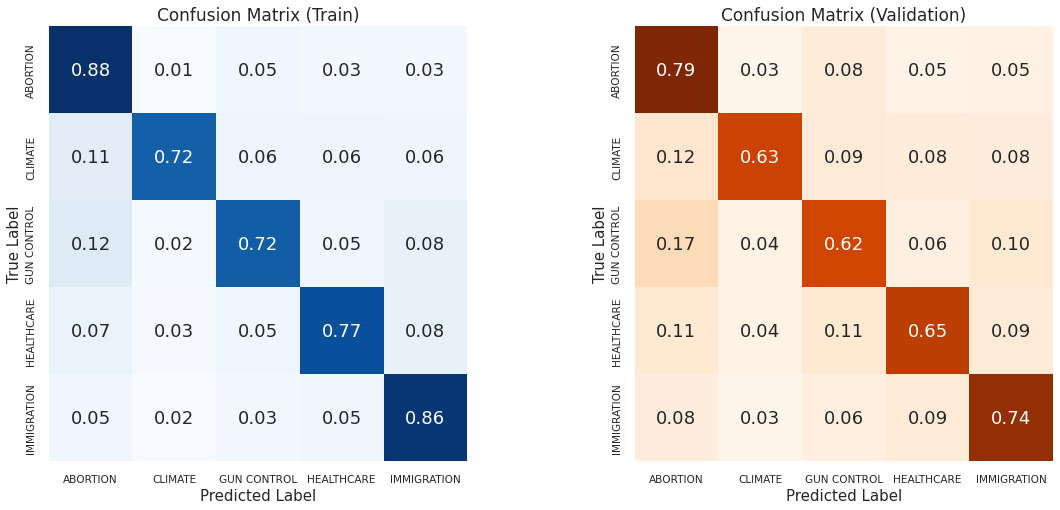

In [258]:
plot_validation_confusion_matrices(y_train_issue_true, 
                                        y_train_issue_pred, 
                                        y_validate_issue_true, 
                                        y_validate_issue_pred, 
                                        target_names=lb_issue.classes_, 
                                        normalize="true", 
                                        sample_weight=issue_weights,
                                        figsize=(18,8),
                                        filepath=f"images/{''.join(MODEL_NAME.split('_'))}/ISSUE-validation-confusion-matrices.png")

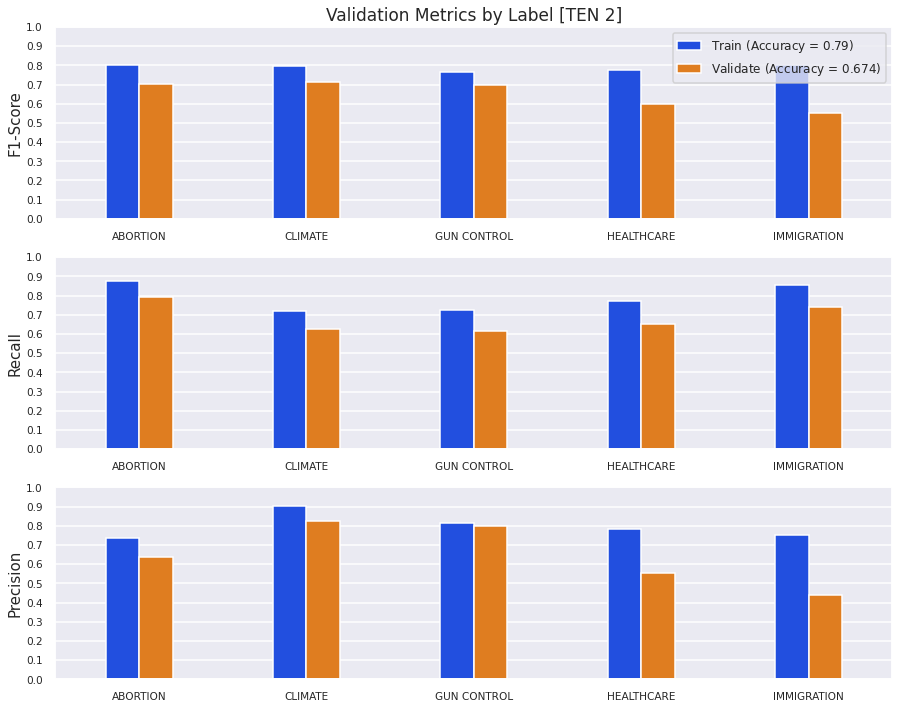

In [259]:
plot_multilabel_validation_metrics(y_train_issue_true, 
                                        y_train_issue_pred, 
                                        y_validate_issue_true, 
                                        y_validate_issue_pred, 
                                        score_names = ['f1-score', 'recall', 'precision'],
                                        score_labels=["F1-Score", "Recall", "Precision"],
                                        target_names=lb_issue.classes_,
                                        estimator_label=f"{' '.join(MODEL_NAME.split('_')).upper()}",
                                        sample_weight=issue_weights,
                                        mode="validate",
                                        filepath=f"images/{''.join(MODEL_NAME.split('_'))}/ISSUE-validation-metrics.png")

In [260]:
ten2_val_metrics_issue = get_classification_metrics(y_validate_issue_true, 
                                                            y_validate_issue_pred, 
                                                            target_names=lb_issue.classes_)

ten2_average_f1_score_issue = ten2_val_metrics_issue.loc["F1-Score"]["Average"]
ten2_average_f1_score_issue

0.653

##### `STANCE`

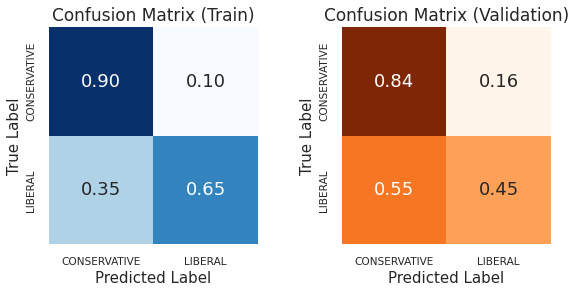

In [261]:
plot_validation_confusion_matrices(y_train_stance_true, 
                            y_train_stance_pred, 
                            y_validate_stance_true, 
                            y_validate_stance_pred, 
                            target_names=lb_stance.classes_, 
                            normalize="true", 
                            sample_weight=stance_weights,
                            figsize=(9,4),
                            filepath=f"images/{''.join(MODEL_NAME.split('_'))}/STANCE-validation-confusion-matrices.png")

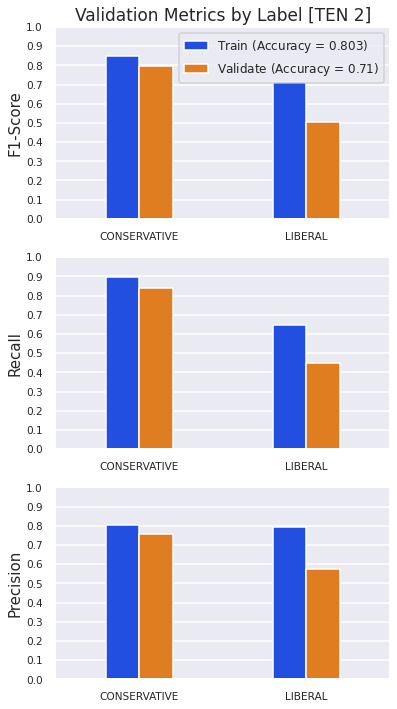

In [273]:
plot_multilabel_validation_metrics(y_train_stance_true, 
                                   y_train_stance_pred, 
                                   y_validate_stance_true, 
                                   y_validate_stance_pred, 
                                   score_names = ['f1-score', 'recall', 'precision'],
                                   score_labels=["F1-Score", "Recall", "Precision"],
                                   target_names=lb_stance.classes_,
                                   estimator_label=f"{' '.join(MODEL_NAME.split('_')).upper()}",
                                   sample_weight=stance_weights,
                                   mode="validate",
                                   filepath=f"images/{''.join(MODEL_NAME.split('_'))}/STANCE-validation-metrics.png")

In [263]:
ten2_val_metrics_stance = get_classification_metrics(y_validate_stance_true, 
                                                            y_validate_stance_pred, 
                                                            target_names=lb_stance.classes_)

ten2_average_f1_score_stance = ten2_val_metrics_stance.loc["F1-Score"]["Average"]
ten2_average_f1_score_stance

0.65

#### *`TEN 3`*

In [284]:
MODEL_NAME = "ten_3"

loaded_model = load_model(f"models/{''.join(MODEL_NAME.split('_'))}.h5", custom_objects={"TransformerEncoder": TransformerEncoder, "PositionalTokenEmbedding": PositionalTokenEmbedding})

y_train_pred = loaded_model.predict(X_train_IE)
y_validate_pred = loaded_model.predict(X_validate_IE)

y_train_issue_pred = lb_issue.inverse_transform(y_train_pred[0])
y_validate_issue_pred = lb_issue.inverse_transform(y_validate_pred[0])

y_train_stance_pred = lb_stance.inverse_transform(y_train_pred[1])
y_validate_stance_pred = lb_stance.inverse_transform(y_validate_pred[1])

291/291 [==============================] - 7s 23ms/step


##### `ISSUE`

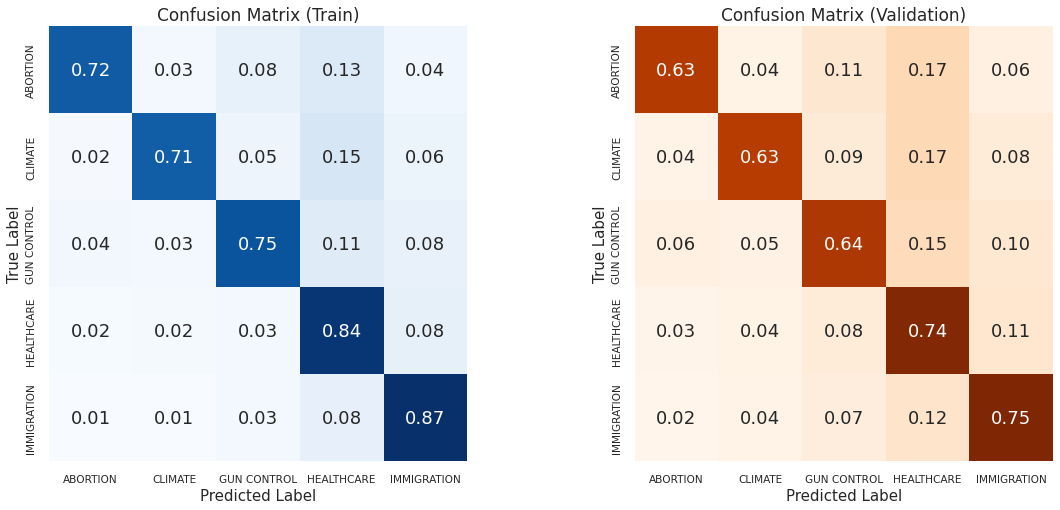

In [265]:
plot_validation_confusion_matrices(y_train_issue_true, 
                                        y_train_issue_pred, 
                                        y_validate_issue_true, 
                                        y_validate_issue_pred, 
                                        target_names=lb_issue.classes_, 
                                        normalize="true", 
                                        sample_weight=issue_weights,
                                        figsize=(18,8),
                                        filepath=f"images/{''.join(MODEL_NAME.split('_'))}/ISSUE-validation-confusion-matrices.png")

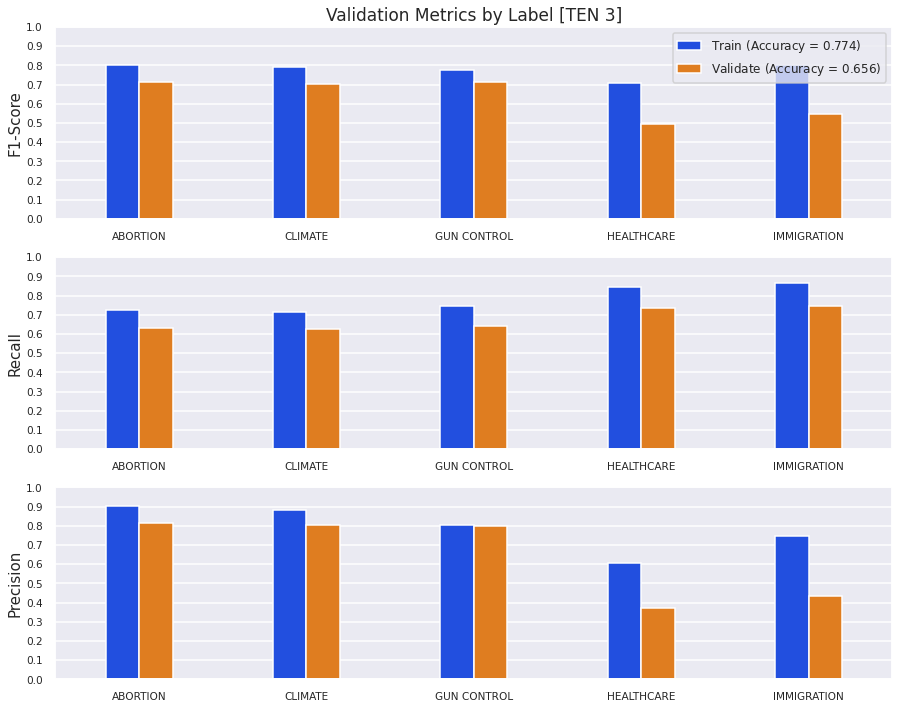

In [266]:
plot_multilabel_validation_metrics(y_train_issue_true, 
                                        y_train_issue_pred, 
                                        y_validate_issue_true, 
                                        y_validate_issue_pred, 
                                        score_names = ['f1-score', 'recall', 'precision'],
                                        score_labels=["F1-Score", "Recall", "Precision"],
                                        target_names=lb_issue.classes_,
                                        estimator_label=f"{' '.join(MODEL_NAME.split('_')).upper()}",
                                        sample_weight=issue_weights,
                                        mode="validate",
                                        filepath=f"images/{''.join(MODEL_NAME.split('_'))}/ISSUE-validation-metrics.png")

In [285]:
ten3_val_metrics_issue = get_classification_metrics(y_validate_issue_true, 
                                                            y_validate_issue_pred, 
                                                            target_names=lb_issue.classes_)

ten3_average_f1_score_issue = ten3_val_metrics_issue.loc["F1-Score"]["Average"]
ten3_average_f1_score_issue

0.634

##### `STANCE`

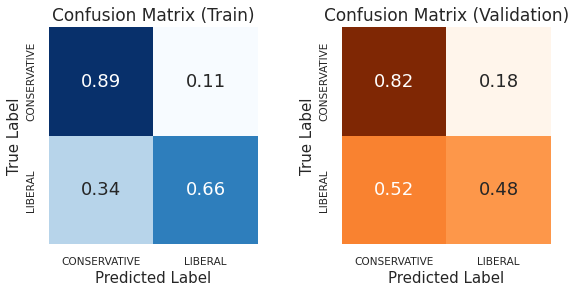

In [268]:
plot_validation_confusion_matrices(y_train_stance_true, 
                            y_train_stance_pred, 
                            y_validate_stance_true, 
                            y_validate_stance_pred, 
                            target_names=lb_stance.classes_, 
                            normalize="true", 
                            sample_weight=stance_weights,
                            figsize=(9,4),
                            filepath=f"images/{''.join(MODEL_NAME.split('_'))}/STANCE-validation-confusion-matrices.png")

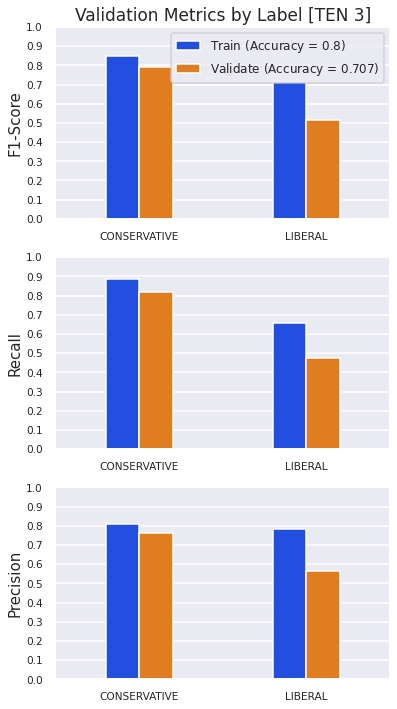

In [275]:
plot_multilabel_validation_metrics(y_train_stance_true, 
                                   y_train_stance_pred, 
                                   y_validate_stance_true, 
                                   y_validate_stance_pred, 
                                   score_names = ['f1-score', 'recall', 'precision'],
                                   score_labels=["F1-Score", "Recall", "Precision"],
                                   target_names=lb_stance.classes_,
                                   estimator_label=f"{' '.join(MODEL_NAME.split('_')).upper()}",                                  
                                   sample_weight=stance_weights,
                                   mode="validate",
                                   filepath=f"images/{''.join(MODEL_NAME.split('_'))}/STANCE-validation-metrics.png")

In [286]:
ten3_val_metrics_stance = get_classification_metrics(y_validate_stance_true, 
                                                            y_validate_stance_pred, 
                                                            target_names=lb_stance.classes_)

ten3_average_f1_score_stance = ten3_val_metrics_stance.loc["F1-Score"]["Average"]
ten3_average_f1_score_stance

0.653

#### *`TEN 4`*

In [337]:
MODEL_NAME = "ten_4"

loaded_model = load_model(f"models/{''.join(MODEL_NAME.split('_'))}.h5", custom_objects={"TransformerEncoder": TransformerEncoder, "PositionalTokenEmbedding": PositionalTokenEmbedding})

y_train_pred = loaded_model.predict(X_train_IE)
y_validate_pred = loaded_model.predict(X_validate_IE)

y_train_issue_pred = lb_issue.inverse_transform(y_train_pred[0])
y_validate_issue_pred = lb_issue.inverse_transform(y_validate_pred[0])

y_train_stance_pred = lb_stance.inverse_transform(y_train_pred[1])
y_validate_stance_pred = lb_stance.inverse_transform(y_validate_pred[1])

291/291 [==============================] - 7s 25ms/step


##### `ISSUE`

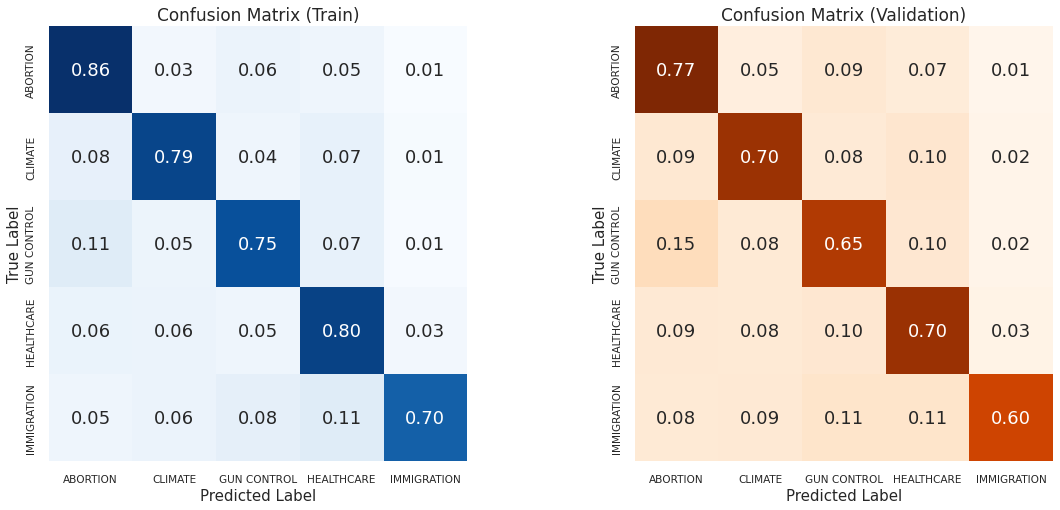

In [338]:
plot_validation_confusion_matrices(y_train_issue_true, 
                                        y_train_issue_pred, 
                                        y_validate_issue_true, 
                                        y_validate_issue_pred, 
                                        target_names=lb_issue.classes_, 
                                        normalize="true", 
                                        sample_weight=issue_weights,
                                        figsize=(18,8),
                                        filepath=f"images/{''.join(MODEL_NAME.split('_'))}/ISSUE-validation-confusion-matrices.png")

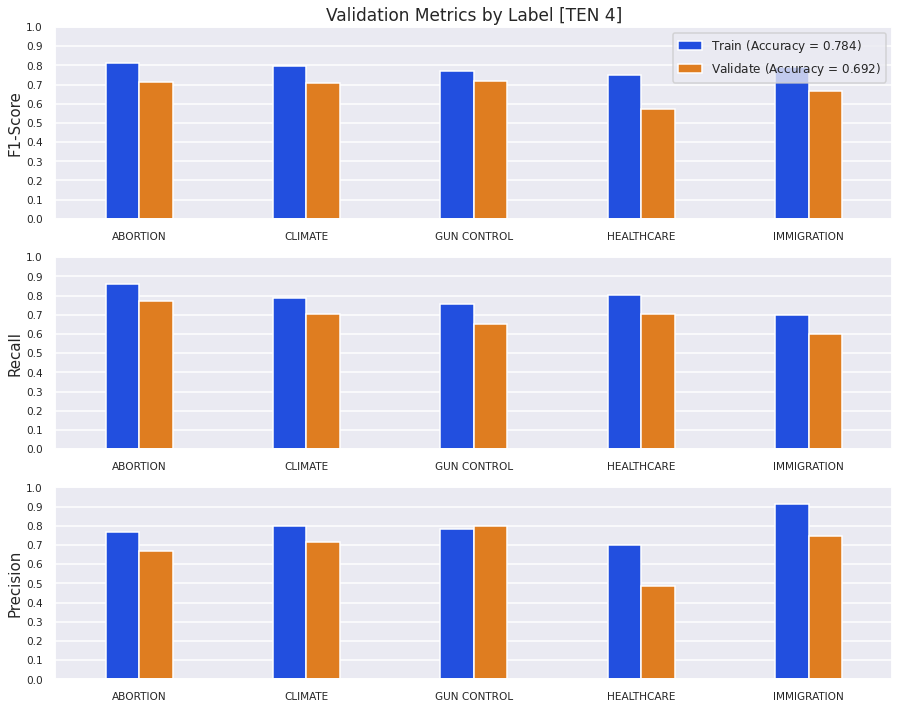

In [339]:
plot_multilabel_validation_metrics(y_train_issue_true, 
                                        y_train_issue_pred, 
                                        y_validate_issue_true, 
                                        y_validate_issue_pred, 
                                        score_names = ['f1-score', 'recall', 'precision'],
                                        score_labels=["F1-Score", "Recall", "Precision"],
                                        target_names=lb_issue.classes_,
                                        estimator_label=f"{' '.join(MODEL_NAME.split('_')).upper()}",
                                        sample_weight=issue_weights,
                                        mode="validate",
                                        filepath=f"images/{''.join(MODEL_NAME.split('_'))}/ISSUE-validation-metrics.png")

In [340]:
ten4_val_metrics_issue = get_classification_metrics(y_validate_issue_true, 
                                                            y_validate_issue_pred, 
                                                            target_names=lb_issue.classes_)

ten4_average_f1_score_issue = ten4_val_metrics_issue.loc["F1-Score"]["Average"]
ten4_average_f1_score_issue

0.677

##### `STANCE`

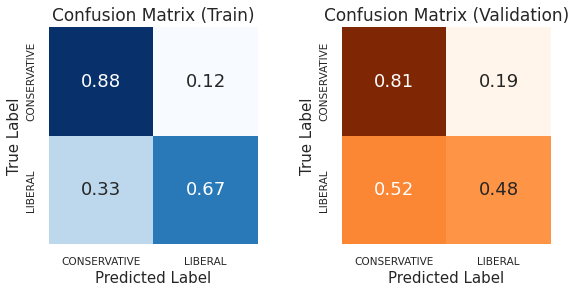

In [341]:
plot_validation_confusion_matrices(y_train_stance_true, 
                            y_train_stance_pred, 
                            y_validate_stance_true, 
                            y_validate_stance_pred, 
                            target_names=lb_stance.classes_, 
                            normalize="true", 
                            sample_weight=stance_weights,
                            figsize=(9,4),
                            filepath=f"images/{''.join(MODEL_NAME.split('_'))}/STANCE-validation-confusion-matrices.png")

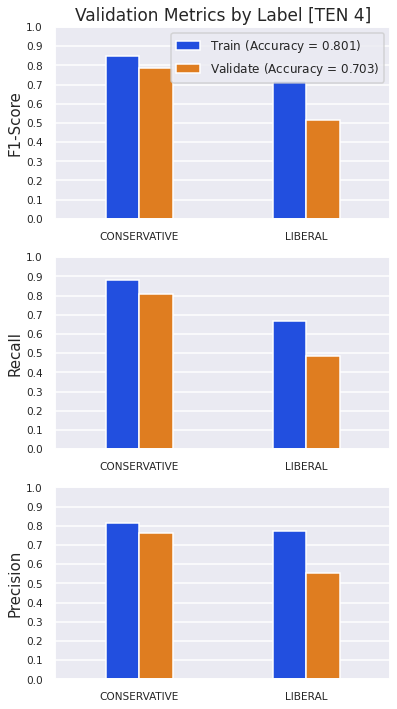

In [342]:
plot_multilabel_validation_metrics(y_train_stance_true, 
                                   y_train_stance_pred, 
                                   y_validate_stance_true, 
                                   y_validate_stance_pred, 
                                   score_names = ['f1-score', 'recall', 'precision'],
                                   score_labels=["F1-Score", "Recall", "Precision"],
                                   target_names=lb_stance.classes_,
                                   estimator_label=f"{' '.join(MODEL_NAME.split('_')).upper()}",
                                   sample_weight=stance_weights,
                                   mode="validate",
                                   filepath=f"images/{''.join(MODEL_NAME.split('_'))}/STANCE-validation-metrics.png")

In [343]:
ten4_val_metrics_stance = get_classification_metrics(y_validate_stance_true, 
                                                            y_validate_stance_pred, 
                                                            target_names=lb_stance.classes_)

ten4_average_f1_score_stance = ten4_val_metrics_stance.loc["F1-Score"]["Average"]
ten4_average_f1_score_stance

0.651

## D.3 - Selecting the Best Architecture

> The models were compared and the network with the highest $F_1\text{-Score}$ (averaged over both the `issue` and `stance` labels) on the Validation Set was chosen as the best model.

In [318]:
model_names = ["DNN 1",
                "DNN 2",
                "DNN 3",
                "DNN 4",
                "DNN 5",
                "TEN 1",
                "TEN 2",
                "TEN 3",
                "TEN 4"]

In [319]:
f1_scores =  [(dnn1_average_f1_score_issue + dnn1_average_f1_score_stance) / 2,
                  (dnn2_average_f1_score_issue + dnn2_average_f1_score_stance) / 2,
                  (dnn3_average_f1_score_issue + dnn3_average_f1_score_stance) / 2,
                  (dnn4_average_f1_score_issue + dnn4_average_f1_score_stance) / 2,
                  (dnn5_average_f1_score_issue + dnn5_average_f1_score_stance) / 2,
                  (ten1_average_f1_score_issue + ten1_average_f1_score_stance) / 2,
                  (ten2_average_f1_score_issue + ten2_average_f1_score_stance) / 2,
                  (ten3_average_f1_score_issue + ten3_average_f1_score_stance) / 2,
                  (ten4_average_f1_score_issue + ten4_average_f1_score_stance) / 2]

In [320]:
f1_scores = pd.Series(dict(zip(model_names, f1_scores))).sort_values(ascending=True)
f1_scores

DNN 2    0.6125
DNN 4    0.6305
DNN 5    0.6340
DNN 1    0.6385
DNN 3    0.6420
TEN 3    0.6435
TEN 2    0.6515
TEN 1    0.6575
TEN 4    0.6640
dtype: float64

> A plot of the average $F_1\text{-Score}$ on the Validation Set for all models, averaged over both the `stance` and `issue` labels, is shown below:

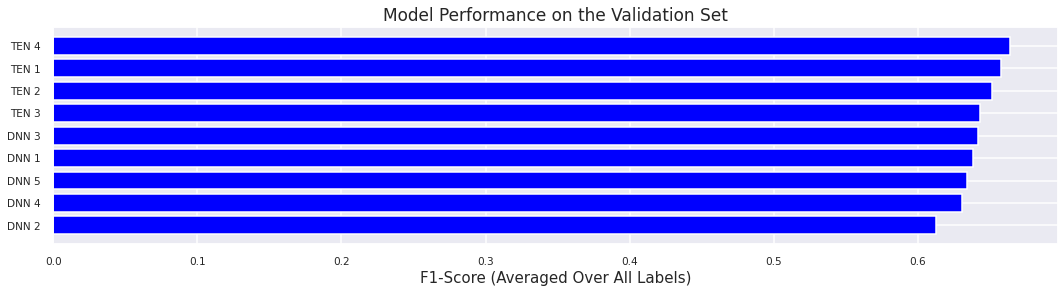

In [321]:
fig, ax = plt.subplots(figsize=(18,4))
ax.barh(y=f1_scores.index, width=f1_scores.values, color="blue")
ax.set(title='Model Performance on the Validation Set', xlabel="F1-Score (Averaged Over All Labels)")
fig.savefig("images/overall-f1-scores.png")

> The above figure shows that `TEN 4` had the highest average $F_1\text{-Score}$, across all labels, on the Validation Set. Therefore, `TEN 4` was chosen as the best model and evaluated against the Test Set.

# E. *Evaluation*

In [322]:
y_test_issue_true = lb_issue.inverse_transform(y_test_issue)
y_test_stance_true = lb_stance.inverse_transform(y_test_stance)

In [323]:
MODEL_NAME = "ten_4"

loaded_model = load_model(f"models/{''.join(MODEL_NAME.split('_'))}.h5", custom_objects={"TransformerEncoder": TransformerEncoder, "PositionalTokenEmbedding": PositionalTokenEmbedding})

291/291 [==============================] - 7s 24ms/step


In [344]:

y_train_pred = loaded_model.predict(X_train_IE)
y_test_pred = loaded_model.predict(X_test_IE)

y_train_issue_pred = lb_issue.inverse_transform(y_train_pred[0])
y_test_issue_pred = lb_issue.inverse_transform(y_test_pred[0])

y_train_stance_pred = lb_stance.inverse_transform(y_train_pred[1])
y_test_stance_pred = lb_stance.inverse_transform(y_test_pred[1])

291/291 [==============================] - 7s 23ms/step


> The  `TEN 4` model was evaluated against the Test Set, its performance with respect to the `stance` and `issue` labels is shown in the plots below.

##### `ISSUE`

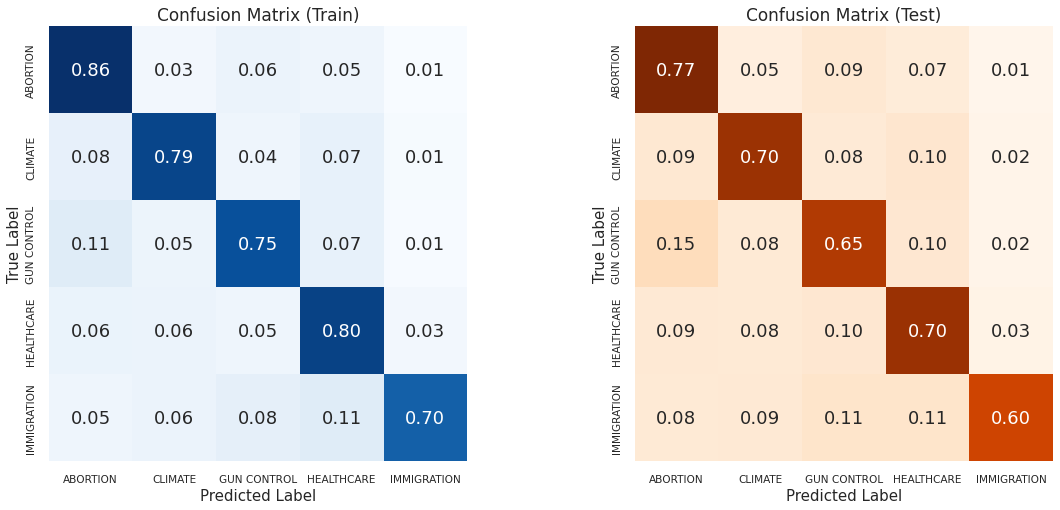

In [345]:
plot_validation_confusion_matrices(y_train_issue_true, 
                                        y_train_issue_pred, 
                                        y_validate_issue_true, 
                                        y_validate_issue_pred, 
                                        target_names=lb_issue.classes_, 
                                        normalize="true", 
                                        sample_weight=issue_weights,
                                        figsize=(18,8),
                                        mode="test",
                                        filepath=f"images/{''.join(MODEL_NAME.split('_'))}/ISSUE-test-confusion-matrices.png")

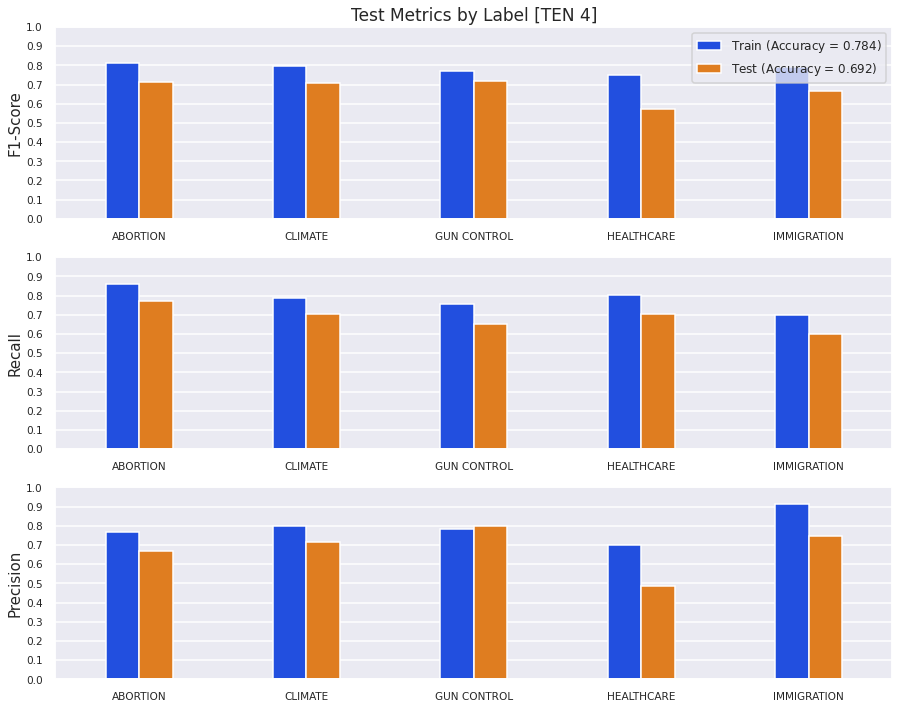

In [347]:
plot_multilabel_validation_metrics(y_train_issue_true, 
                                        y_train_issue_pred, 
                                        y_validate_issue_true, 
                                        y_validate_issue_pred, 
                                        score_names = ['f1-score', 'recall', 'precision'],
                                        score_labels=["F1-Score", "Recall", "Precision"],
                                        target_names=lb_issue.classes_,
                                        estimator_label=f"{' '.join(MODEL_NAME.split('_')).upper()}",
                                        sample_weight=issue_weights,
                                        mode="test",
                                        filepath=f"images/{''.join(MODEL_NAME.split('_'))}/ISSUE-test-metrics.png")

##### `STANCE`

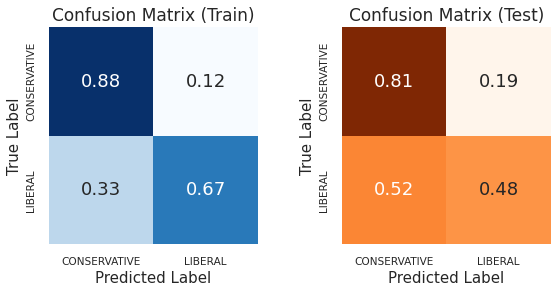

In [348]:
plot_validation_confusion_matrices(y_train_stance_true, 
                            y_train_stance_pred, 
                            y_validate_stance_true, 
                            y_validate_stance_pred, 
                            target_names=lb_stance.classes_, 
                            normalize="true", 
                            sample_weight=stance_weights,
                            figsize=(9,4),
                            mode="test",
                            filepath=f"images/{''.join(MODEL_NAME.split('_'))}/STANCE-test-confusion-matrices.png")

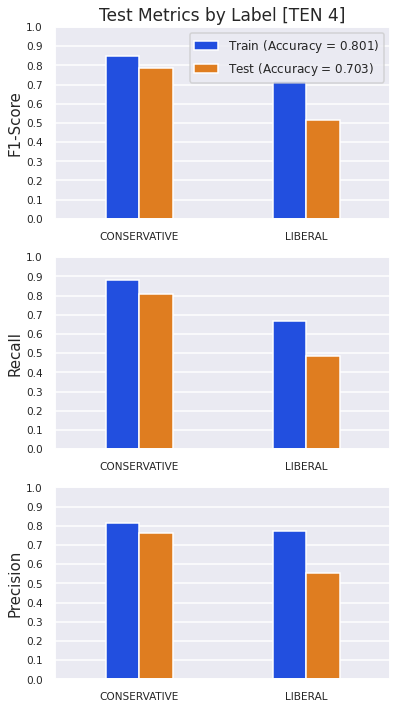

In [349]:
plot_multilabel_validation_metrics(y_train_stance_true, 
                                   y_train_stance_pred, 
                                   y_validate_stance_true, 
                                   y_validate_stance_pred, 
                                   score_names = ['f1-score', 'recall', 'precision'],
                                   score_labels=["F1-Score", "Recall", "Precision"],
                                   target_names=lb_stance.classes_,
                                   estimator_label=f"{' '.join(MODEL_NAME.split('_')).upper()}",                                   
                                   sample_weight=stance_weights,
                                   mode="test",
                                   filepath=f"images/{''.join(MODEL_NAME.split('_'))}/STANCE-test-metrics.png")

The performances of the `RNN 4` model on the Training Set and Test Set are compared in the plots below:

The performance of `RNN 4` on the Test Set is summarized as follows:

> - Adequate recall when classifying POSITIVE tweets:
>   - $74\%$ of all POSITIVE tweets in the Test Set were labeled correctly
> - Very good precision when classifying POSITIVE tweets:
>   - $87\%$ of all POSITIVE predictions made by the model were correct
> - Good overall performance on the POSITIVE tweets $(F_{1, \text{POSITIVE}} = 0.798)$
---
> - Very good recall when classifying NEUTRAL tweets:
>   - $87\%$ of all NEUTRAL tweets in the Test Set were labeled correctly
> - Adequate precision when classifying NEUTRAL tweets:
>   - $73\%$ of all NEUTRAL predictions made by the model were correct
> - Good overall performance on the NEUTRAL tweets $(F_{1, \text{NEUTRAL}} = 0.796)$
---
> - Good recall when classifying NEGATIVE tweets:
>   - $80\%$ of all NEGATIVE tweets in the Test Set were labeled correctly
> - Good precision when classifying NEGATIVE tweets:
>   - $80\%$ of all NEGATIVE predictions made by the model were correct
> - Good overall performance on the NEGATIVE tweets $(F_{1, \text{NEGATIVE}} = 0.799)$
---
> - Overall, the model had a solid performance on the Test Set:
>   - $F_{1,\text{avg}} = 0.798$
> - The model's ability to generalize to unseen data needs some improvement:
>   - $2.3\%$ loss in accuracy indicates some overfitting

# G. *Limitations and Future Work*

### Imbalance of Data

The data was highly imbalanced, and so some labels were represented far more than others. All models performed noticeably worse when attempting to predict the labels that were not well represented in the dataset. The most noticeable examples of this were the `LIBERAL`, `IMMIGRATION`, and `HEALTHCARE` labels. Since there were less than half as many `LIBERAL` comments as there were `CONSERVATIVE` ones, the performance of every single model suffered when predicting `LIBERAL` comments on the Validation Set. This also occured for the `HEALTHCARE` and `IMMIGRATION` labels, which comprised of just $11\%$ and $9\%$ of all comments used in the analysis.

### Quantity of Data

Considering there was effectively $10$ different sets of classes, more data was simply needed. In order to remedy this, more comments need to be scraped from the Reddit API. Another way of collecting more data would be to scrape comments from Conservative/Liberal Subreddits and then use unsupervised learning techniques (like clustering) to separate these comments into different topics.

### Choice of Issues

The set of $5$ issues chosen for this analysis were by no means exhaustive. For example, issue related to government spending and the state of the economy were left out. For remote canvassing to work, the model must know how to identify a more comprehensive list of issues than the ones used in this analysis. Thus, a more complete list of issues needs to be defined, and the model built around identifying one or more of these issues in a comment.

### Filtering Out Irrelevant Comments

The geatest limitation of the models developed in this analysis is that they cannot identify irrelevant comments. Thus, one would have to know beforehand whether or not the comments they are feeding to the model are indeed related to one of the politically important issues it knows how to identify. To remedy this, one could implement a system that identifies certain keywords or entities, and filters comments appropriately, before feeding them into the model. Otherwise, resources would be wasted feeding the model irrelevant data.